# EDA

In [2]:
import os
import ast
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

from pandas import json_normalize

## 1. 전체 데이터 파악

In [33]:
train_path = 'new_train.csv'

In [34]:
train_df = pd.read_csv(train_path)

/var/folders/l3/cq8y8n3s03v315zt58m2zrv80000gn/T/ipykernel_84143/1042924200.py:1: DtypeWarning:

Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.



In [35]:
train_df.head()

,channelGrouping,customDimensions,date,device,fullVisitorId,geoNetwork,hits,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Direct,"[{'index': '4', 'value': 'North America'}]",20160801,"{""browser"": ""Safari"", ""browserVersion"": ""not a...",6849420071276447389,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""33"", ""pageviews"": ""13...","{""campaign"": ""(not set)"", ""source"": ""(direct)""...",1470074045,1,1470074045
1,Referral,"[{'index': '4', 'value': 'North America'}]",20160801,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1231590494443171080,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '8', ...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""31"", ""pageviews"": ""23...","{""referralPath"": ""/"", ""campaign"": ""(not set)"",...",1470067091,2,1470067091
2,Direct,"[{'index': '4', 'value': 'North America'}]",20160801,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",6751290259214798595,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '6', ...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""31"", ""pageviews"": ""21...","{""campaign"": ""(not set)"", ""source"": ""(direct)""...",1470056945,1,1470056945
3,Referral,"[{'index': '4', 'value': 'North America'}]",20160801,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3213840074316400693,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '6', ...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""32"", ""pageviews"": ""24...","{""referralPath"": ""/"", ""campaign"": ""(not set)"",...",1470057237,2,1470057237
4,Referral,"[{'index': '4', 'value': 'North America'}]",20160801,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",2987126973357946088,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '21',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""32"", ""pageviews"": ""24...","{""referralPath"": ""/"", ""campaign"": ""(not set)"",...",1470112710,1,1470112710


- 데이터 수집 기간 파악

In [36]:
print('수집 시작 : ', str(train_df['date'].sort_values(ascending=True).iloc[0]))
print('수집 종료 : ', str(train_df['date'].sort_values(ascending=True).iloc[-1]))


수집 시작 :  20160801
수집 종료 :  20170801


- 컬럼 확인

In [37]:
train_df.columns

Index(['channelGrouping', 'customDimensions', 'date', 'device',
       'fullVisitorId', 'geoNetwork', 'hits', 'socialEngagementType', 'totals',
       'trafficSource', 'visitId', 'visitNumber', 'visitStartTime'],
      dtype='object')

- 데이터셋 개요

In [38]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   channelGrouping       903653 non-null  object
 1   customDimensions      903653 non-null  object
 2   date                  903653 non-null  int64 
 3   device                903653 non-null  object
 4   fullVisitorId         903653 non-null  object
 5   geoNetwork            903653 non-null  object
 6   hits                  903653 non-null  object
 7   socialEngagementType  903653 non-null  object
 8   totals                903653 non-null  object
 9   trafficSource         903653 non-null  object
 10  visitId               903653 non-null  int64 
 11  visitNumber           903653 non-null  int64 
 12  visitStartTime        903653 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 89.6+ MB


## nested data 값을 가지는 컬럼 펼치기

In [3]:
def load_df(csv_path):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']

    df = pd.read_csv(csv_path,
                     converters={column: json.loads for column in JSON_COLUMNS},
                     dtype={'fullVisitorId': 'str'} # Important!!
                    )

    for column in JSON_COLUMNS:
        column_as_df = pd.json_normalize(df[column])  # ✅ 최신 방식 적용
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df


In [13]:
train_df = load_df('new_train.csv')

Loaded new_train.csv. Shape: (903653, 60)


In [14]:
train_df.head()

,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.timeOnSite,totals.newVisits,totals.transactions,totals.transactionRevenue,totals.totalTransactionRevenue,totals.bounces,totals.sessionQualityDim,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.referralPath,trafficSource.keyword,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.campaignCode
0,Direct,"[{'index': '4', 'value': 'North America'}]",20160801,6849420071276447389,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,1470074045,1,1470074045,Safari,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,Massachusetts,Boston MA-Manchester NH,Cambridge,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,33,13,129,1,NaN,NaN,NaN,NaN,NaN,(not set),(direct),(none),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Referral,"[{'index': '4', 'value': 'North America'}]",20160801,1231590494443171080,"[{'hitNumber': '1', 'time': '0', 'hour': '8', ...",Not Socially Engaged,1470067091,2,1470067091,Chrome,not available in demo dataset,not available in demo dataset,Chrome OS,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Mountain View,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,1,31,23,1380,NaN,NaN,NaN,NaN,NaN,NaN,(not set),(direct),(none),NaN,not available in demo dataset,/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Direct,"[{'index': '4', 'value': 'North America'}]",20160801,6751290259214798595,"[{'hitNumber': '1', 'time': '0', 'hour': '6', ...",Not Socially Engaged,1470056945,1,1470056945,Chrome,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not 

In [15]:
train_df.columns

Index(['channelGrouping', 'customDimensions', 'date', 'fullVisitorId', 'hits',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.browserVersion', 'device.browserSize',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.isMobile', 'device.mobileDeviceBranding',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.flashVersion', 'device.language', 'device.screenColors',
       'device.screenResolution', 'device.deviceCategory',
       'geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country',
       'geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.networkDomain', 'geoNetwork.latitude',
       'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits',
       'totals.hits', 'totals.pageviews', 'totals.timeOnSite',
       'totals.new

수익이 발생한 행을 히스토그램으로 확인
- 지표 : totals.transactionRevenue

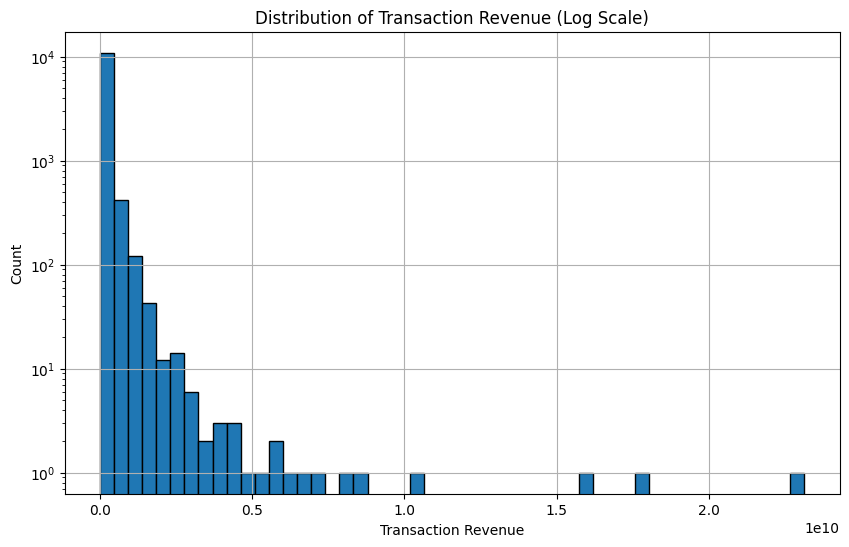

In [16]:
# 수익 데이터를 숫자로 변환 (결측치는 0으로 처리)
train_df['totals.transactionRevenue'] = pd.to_numeric(train_df['totals.transactionRevenue'], errors='coerce').fillna(0)

# 수익이 발생한 방문자 데이터 필터링 (시각화에만 사용)
revenue_users = train_df[train_df['totals.transactionRevenue'] > 0]

# 수익 분포 시각화
plt.figure(figsize=(10,6))
plt.hist(revenue_users['totals.transactionRevenue'], bins=50, edgecolor='black', log=True)
plt.xlabel("Transaction Revenue")
plt.ylabel("Count")
plt.title("Distribution of Transaction Revenue (Log Scale)")
plt.grid(True)
plt.show()

매출의 80%는 상위 20%의 고객으로부터 발생한다는 **파레토 법칙**을 잘 보여준다. 대부분의 방문자는 거래 수익이 낮고 주로 소수의 고객이 매우 높은 거래 수익을 발생시키는 것으로 보임. Y축은 극단적인 값들을 더 직관적으로 보기 위해 로그 스케일 사용

Point :
1. VIP 고객 분석 필요 -> 반복 구매 및 구매 패턴을 파악해 마케팅 전략 수립
2. 저수익 고객 분석 필요 -> 방문은 하지만 구매하지 않는 고객의 특징을 파악하여 전환율 향상이 기대됨.
---
진행해 볼 수 있는 분석 예시 :
1. VIP 고객 특징 분석 -> 어떤 고객이 높은 수익을 창출하는지 분석
2. 구매 전환율 개선 -> 저수익 고객을 어떻게 유도할 수 있을지 탐색
3. 유사 고객 타겟팅 -> VIP 고객과 유사한 특징을 가진 신규 고객을 유치하는 전략 수립.

# 1. VIP 고객 특징 분석
VIP 고객이 매출의 큰 부분을 차지하는 것으로 확인

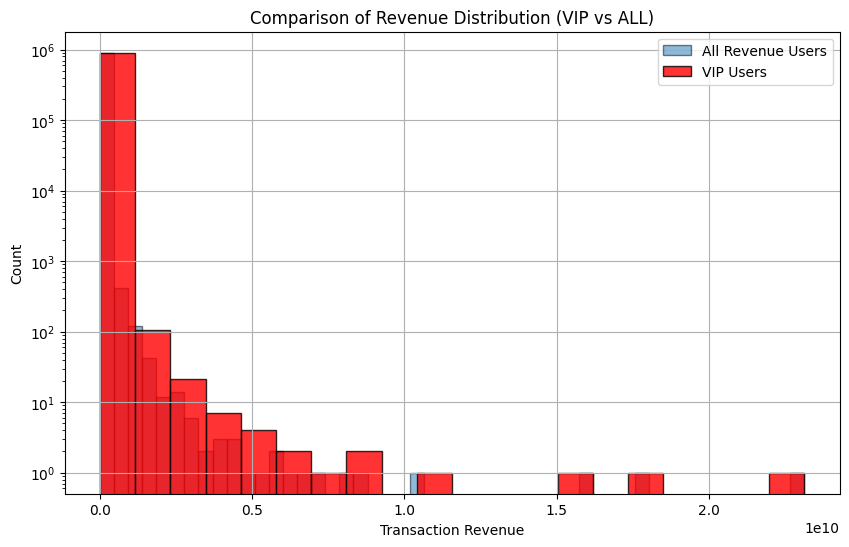

In [17]:
# VIP 고객 기준 : 상위 5% 수익 고객
vip_threshod = train_df['totals.transactionRevenue'].quantile(0.95)
vip_users = train_df[train_df['totals.transactionRevenue'] >= vip_threshod]

# 수익 분포 시각화 (VIP 고객 vs 일반 고객)
plt.figure(figsize=(10, 6))
plt.hist(train_df['totals.transactionRevenue'], bins=50, alpha=0.5, label='All Revenue Users', log=True, edgecolor='black')
plt.hist(vip_users['totals.transactionRevenue'], bins=20, alpha=0.8, label='VIP Users', log=True, edgecolor='black', color='red')

plt.xlabel("Transaction Revenue")
plt.ylabel("Count")
plt.title("Comparison of Revenue Distribution (VIP vs ALL)")
plt.legend()
plt.grid(True)

plt.show()

- 파란색 (All Revenue Users) : 전체 사용자들의 거래 수익 분포
- 빨간색 (VIP Users, 상위 5%) : 수익이 높은 VIP 고객들의 거래 수익 분포

VIP 고객의 특징
VIP 고객이 매출의 대부분을 차지 -> 상위 5% 고객이 거래 수익에서 큰 비중을 차지하며, 일부 고객은 극단적으로 높은 수익을 기록.

거래 수익의 분포가 넓음 -> 일부 VIP 고객의 거래 수익은 1.5 ~ 2.0 x 10^10 수준으로 상당히 높음

VIP 고객들의 공통적은 특성을 파악해보자.

먼저 VIP 고객의 기기 유형 분석(device)

/var/folders/l3/cq8y8n3s03v315zt58m2zrv80000gn/T/ipykernel_96762/14801382.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




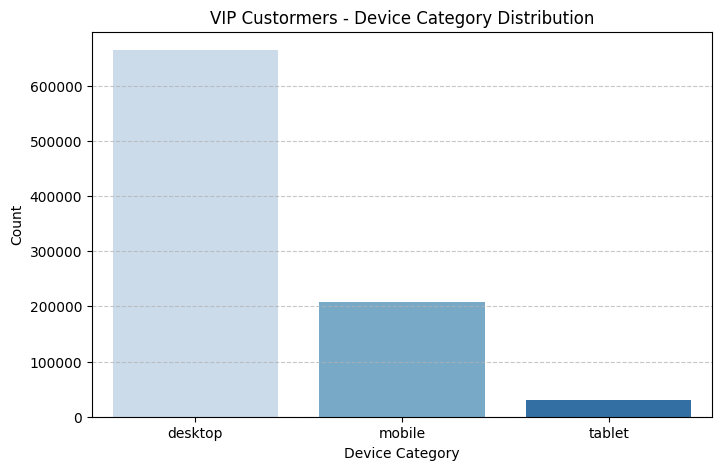

In [18]:
# 기기 유형 분석 (PC vs Mobile)
plt.figure(figsize=(8,5))
sns.countplot(data=vip_users, x='device.deviceCategory', order=vip_users['device.deviceCategory'].value_counts().index, palette='Blues')
plt.xlabel("Device Category")
plt.ylabel("Count")
plt.title("VIP Custormers - Device Category Distribution")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

대부분의 VIP 고객은 데스크탑을 사용

모바일 사용자비중은 매우 낮음. 즉, 고액 결제는 주로 데스크탑에서 이루어짐. 

모바일 구매가 주를 이루는 상황에서 데스크탑 결제는 사적인 용도가 아닐 확률이 있어보임(회사용, 업무용, 매입 등등)

/var/folders/l3/cq8y8n3s03v315zt58m2zrv80000gn/T/ipykernel_96762/2930473767.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




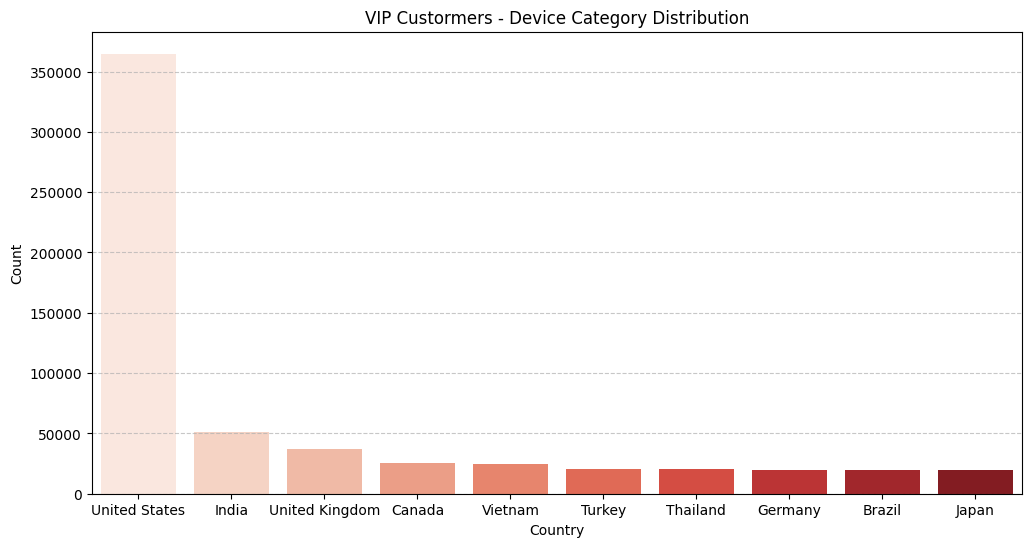

In [23]:
# 국가별 VIP 고객 분포
top_countries = vip_users['geoNetwork.country'].value_counts().head(10) # 상위 10개 국가

plt.figure(figsize=(12, 6))
sns.barplot(x=top_countries.index, y=top_countries.values, palette='Reds')
plt.xlabel("Country")
plt.ylabel("Count")
plt.title("VIP Custormers - Device Category Distribution")
plt.grid(axis="y", linestyle='--', alpha=0.7)
plt.show()

미국(United States)이 압도적으로 많음 -> VIP 고객의 주요 타겟 국가

캐나다, 일본, 케냐, 호주 등 일부 국가에서도 VIP 고객이 발생

미국 위주의 마케팅을 생각해 볼 수 있음

/var/folders/l3/cq8y8n3s03v315zt58m2zrv80000gn/T/ipykernel_96762/1513701692.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




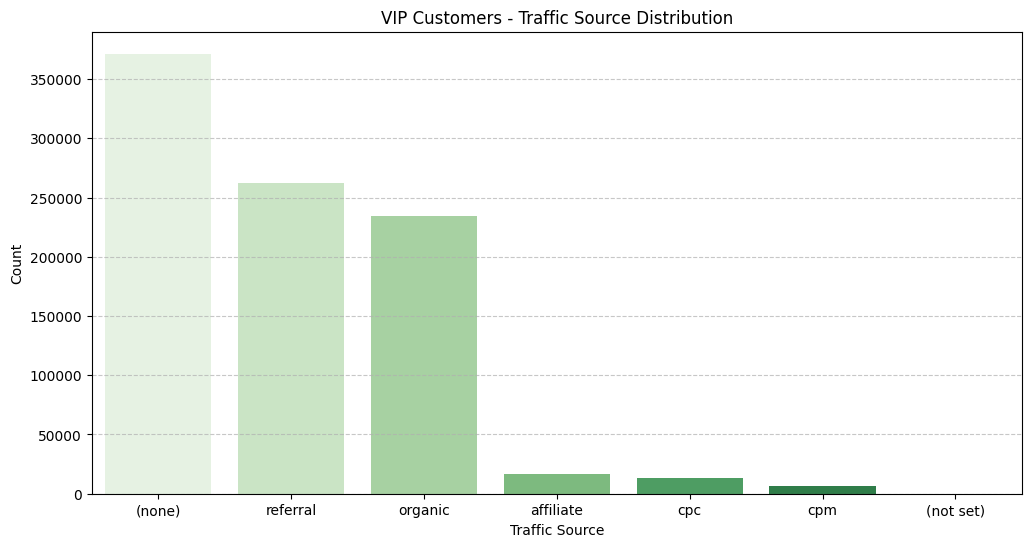

In [24]:
# VIP 고객 유입 경로 분석
plt.figure(figsize=(12, 6))
sns.countplot(data=vip_users, x='trafficSource.medium', order=vip_users['trafficSource.medium'].value_counts().index, palette='Greens')
plt.xlabel("Traffic Source")
plt.ylabel("Count")
plt.title("VIP Customers - Traffic Source Distribution")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

VIP 고객 주요 유입 경로 :

- none(direct) : 브라우저에 URL을 직접 입력하거나 북마크를 사용해 유입된 트래픽, 보다 정확한 정의는 referrer가 없는 트래픽을 말함

- referral(추천) : 검색 엔진의 검색 결과에 표시된 링크를 제외하고 특정 웹사이트에서 다른 웹사이트로 연결되는 링크를 통해 유입된 트래픽(예시 : 네이버 블로그/카페, 언론사 사이트 등)

- organic(자연검색) : 네이버, 구글, 다음 등 검색 엔진의 검색 결과 페이지에서 링크를 클릭하여 웹사이트로 유입된 트래픽

- affiliate Traffic Source : Referral 채널 중에서도 어떤 사이트는 웹사이트 브랜드와 제휴를 맺은 사이트거나 자사 브랜드의 계열사 일 수 있다. 이러한 채널을 통해 유입된 트래픽

- cpc (cost per click, 클릭당 비용) : 특정 광고 시스템에서 집행한 광고를 클릭하여 유입된 트래픽

- cpm (cost per mile, 노출당 비용) : 노출된 광고를 본 고객의 브라우저에 쿠키가 저장됐을 때, 해당 고객이 사이트 방문 시 cpm으로 분류

VIP 고객들은 주로 직접 입력, 추천 경로, 자연 검색 등의 경로를 통해 유입되었음. 상대적으로 광고 효과(cpc, cpm)는 미미했음.
- VIP 고객 대상 마케팅 전략은 광고보다는 직접적인 웹사이트 방문 유도 및 추천 활성화에 초점을 맞춰야 함. SEO(Search Engine Opitimization, 검색 엔진 최적화) 전략을 강화하여 자연 검색을 통한 VIP 고객 유입을 늘릴 필요가 있음

In [35]:
# 전체 방문자 수 (고유한 사용자 수)
total_users = len(train_df['fullVisitorId'].unique())

# 수익을 창출한 방문자 수 (transactionRevenue > 0 인 사용자)
revenue_users = len(train_df[train_df['totals.transactionRevenue'] > 0]['fullVisitorId'].unique())

# 전체 방문 세션 수
total_sessions = len(train_df)

# 수익을 창출한 방문 세션 수
revenue_sessions = len(train_df[train_df['totals.transactionRevenue'] > 0])

# 결과 출력
print(f"전체 방문자 수 : {total_users}")
print(f"수익을 창출한 방문자 수 : {revenue_users} ({(revenue_users / total_users) * 100:.2f}%)")
print(f"전체 방문 세션 수 : {total_sessions}")
print(f"수익을 창출한 방문 세션 수 : {revenue_sessions} ({(revenue_sessions / total_sessions) * 100:.2f}%)")

전체 방문자 수 : 718217
수익을 창출한 방문자 수 : 10047 (1.40%)
전체 방문 세션 수 : 903653
수익을 창출한 방문 세션 수 : 11515 (1.27%)


수익을 창출한 방문자 수는 1.4%로 소수의 방문자 만이 구매로 이어졌고 구매전환율도 1.27%로 평균치(1~3%)보다 약간 낮은 편이다.

# 2. Device 그룹 분석

In [36]:
# device 관련 컬럼 리스트
device_columns = [col for col in train_df.columns if col.startswith('device.')]

# 일정한 값(변하지 않는 값)만 가진 컬럼 찾기
constant_features = [col for col in device_columns if train_df[col].nunique() == 1]

# constant features를 제외한 device 관련 컬럼
important_device_columns = [col for col in device_columns if col not in constant_features]

important_device_columns

['device.browser',
 'device.operatingSystem',
 'device.isMobile',
 'device.deviceCategory']

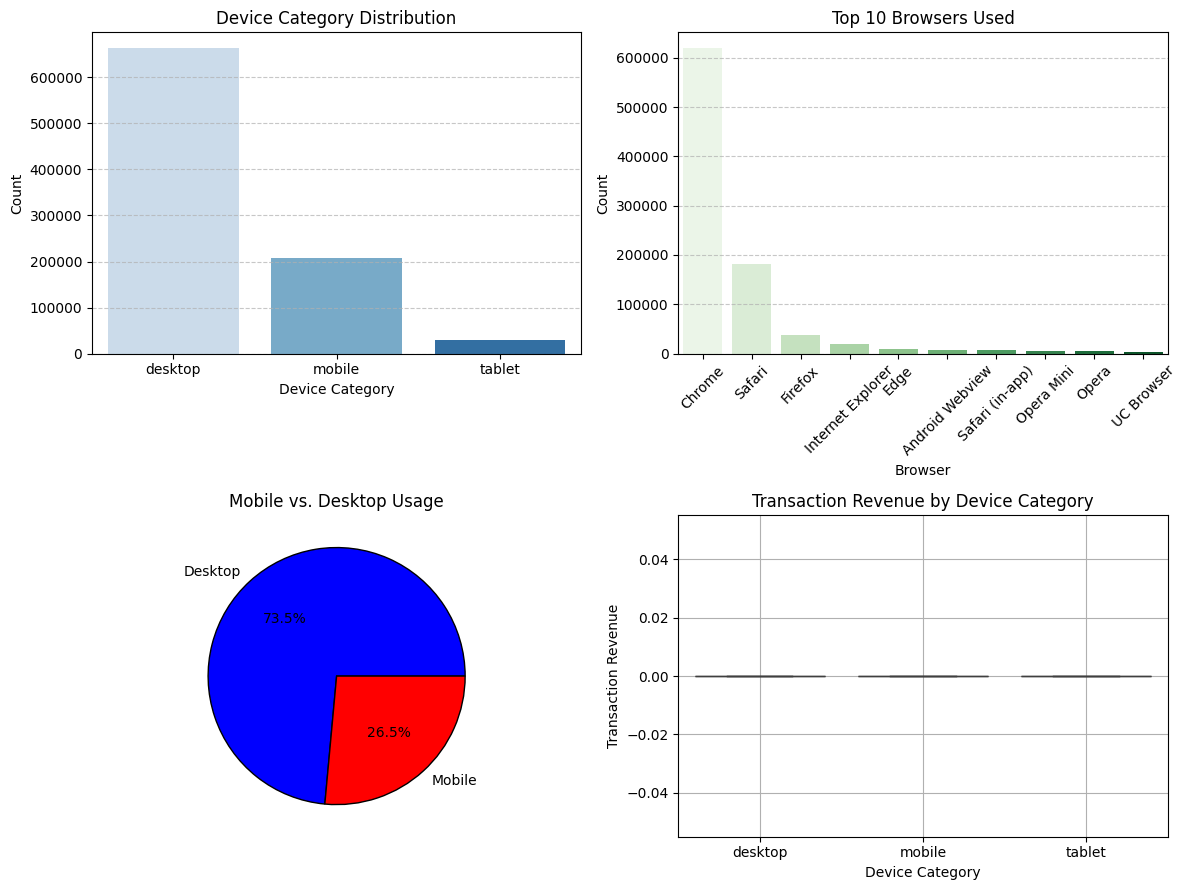

In [39]:
flg, axes = plt.subplots(2, 2, figsize=(12, 9)) # 2x2 형태로 정렬

# 1. Device Category 분석 (막대 그래프)
sns.countplot(data=train_df, x='device.deviceCategory', palette='Blues', hue='device.deviceCategory', ax=axes[0, 0], legend=False)
axes[0,0].set_xlabel('Device Category')
axes[0,0].set_ylabel('Count')
axes[0,0].set_title('Device Category Distribution')
axes[0,0].grid(axis='y', linestyle='--', alpha=0.7)

# 2. Browser 분석 (상위 10개, 막대 그래프)
top_browsers = train_df['device.browser'].value_counts().head(10)
sns.barplot(x=top_browsers.index, y=top_browsers.values, hue=top_browsers.index, palette='Greens', ax=axes[0, 1])
axes[0,1].set_xlabel('Browser')
axes[0,1].set_ylabel('Count')
axes[0,1].set_title('Top 10 Browsers Used')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(axis='y', linestyle='--', alpha=0.7)

# 3. isMobile 분석 (원형 그래프)
is_mobile_counts = train_df['device.isMobile'].value_counts()
labels = ['Desktop', 'Mobile']
axes[1,0].pie(is_mobile_counts, labels=labels, autopct='%1.1f%%', colors=['blue', 'red'], wedgeprops={'edgecolor':'black'})
axes[1,0].set_title("Mobile vs. Desktop Usage")

# 4. Device Category별 거래 수익 비교 (박스 플롯)
sns.boxplot(data=train_df, x='device.deviceCategory', y='totals.transactionRevenue', showfliers=False, ax=axes[1,1])
axes[1,1].set_xlabel("Device Category")
axes[1,1].set_ylabel("Transaction Revenue")
axes[1,1].set_title("Transaction Revenue by Device Category")
axes[1,1].grid(True)

# 레이아웃 조정
plt.tight_layout()
plt.show()

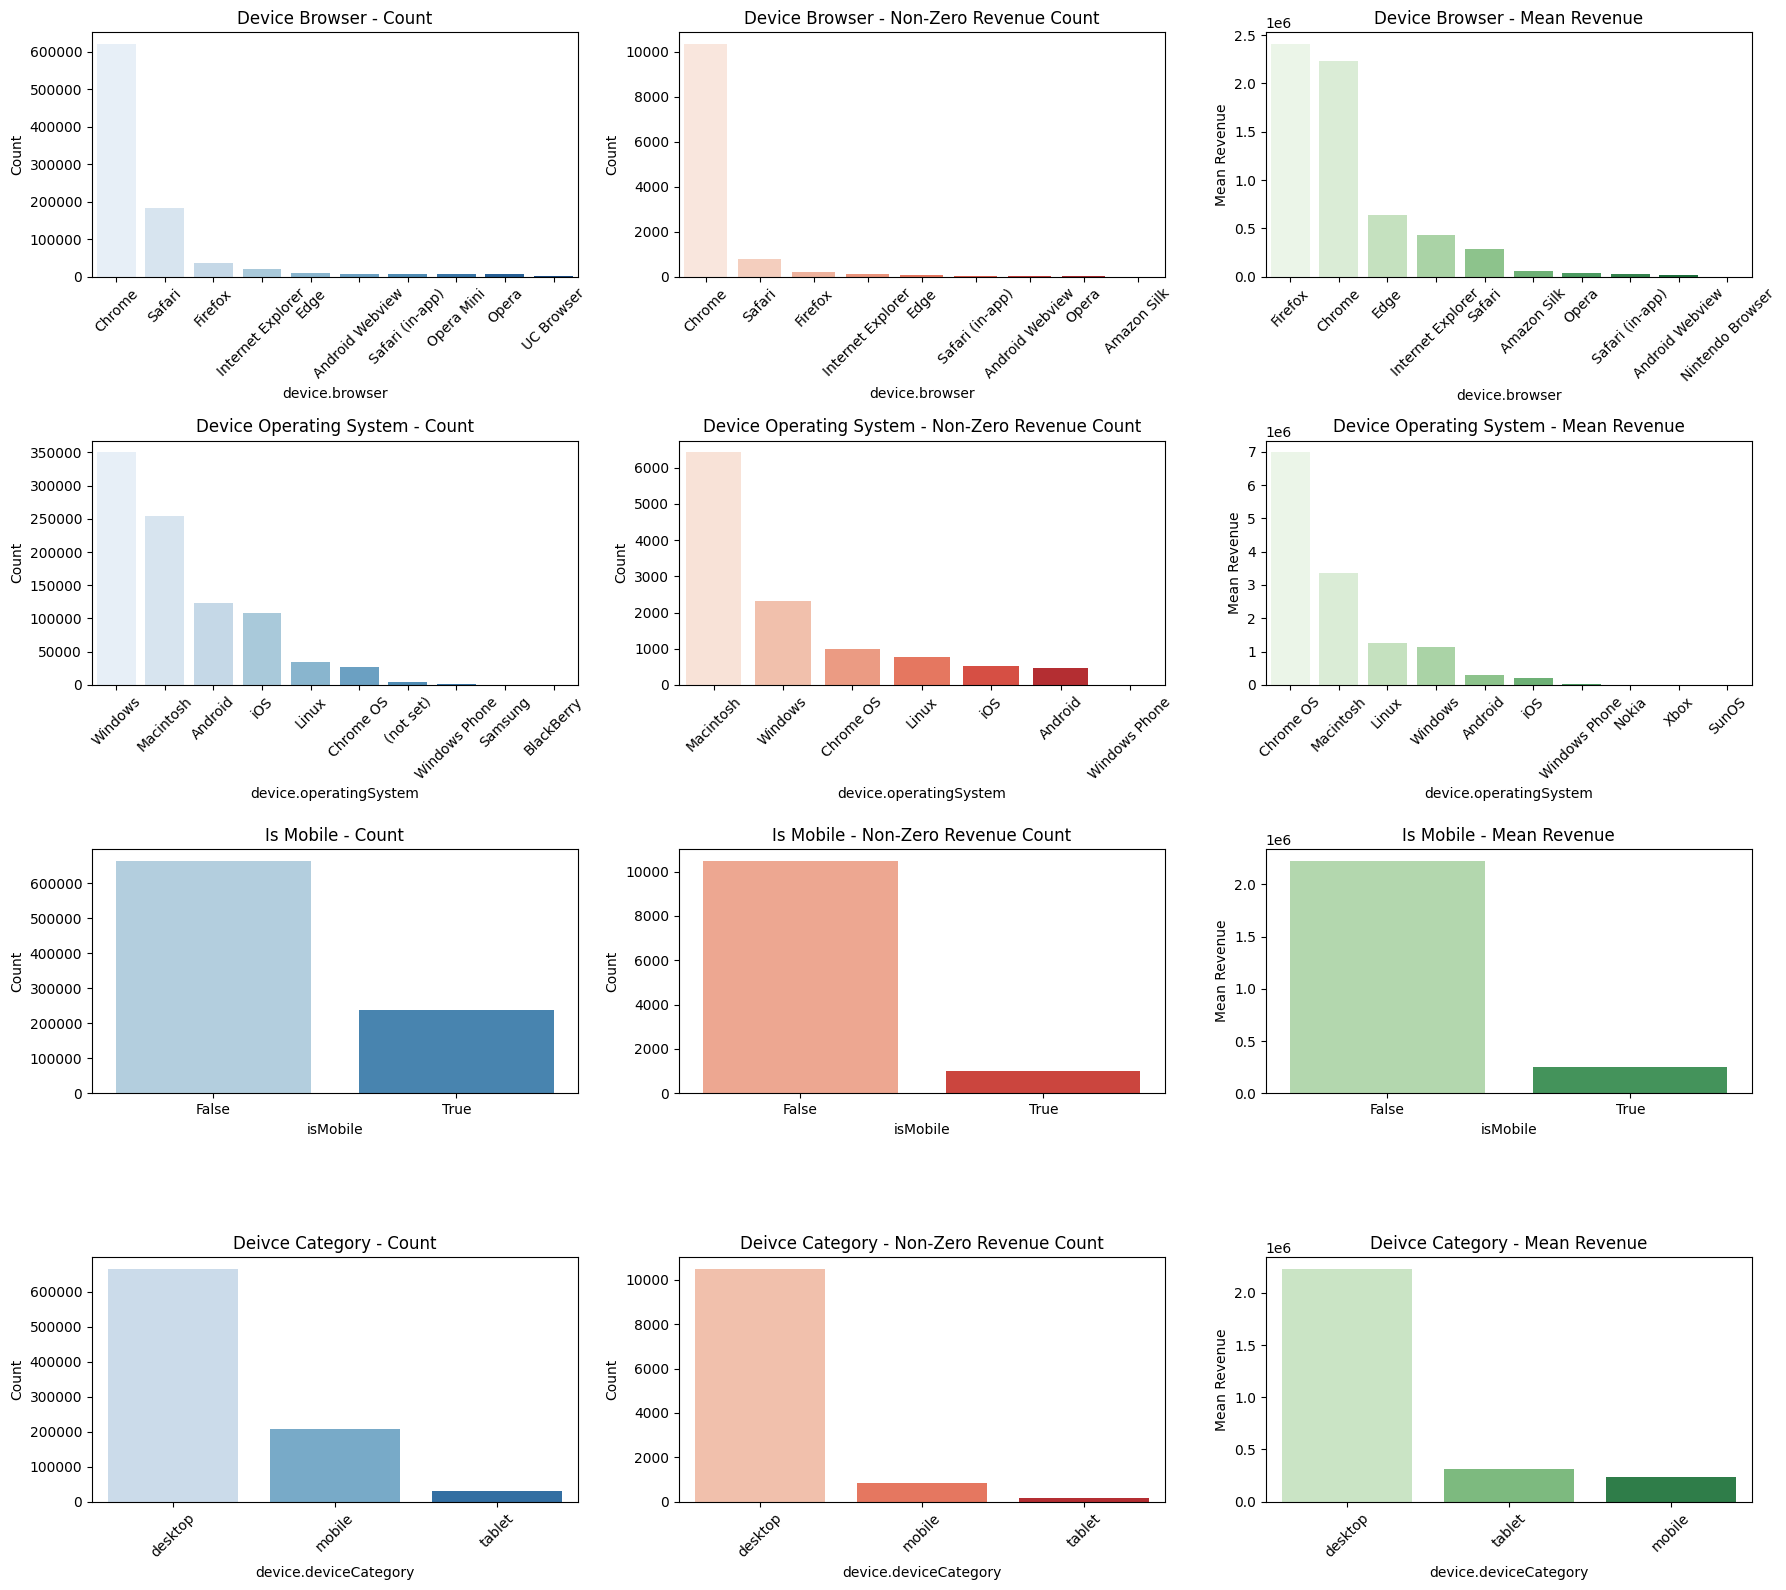

In [47]:
# categorical analysis을 위한 subplot 생성 함수
def plot_categorical_analysis(feature, title, ax1, ax2, ax3) :
    # 전체 count
    count_data = train_df[feature].value_counts().head(10)
    sns.barplot(x=count_data.index, y=count_data.values, hue=count_data.index, legend=False, palette='Blues', ax=ax1)
    ax1.set_title(f"{title} - Count")
    ax1.set_xlabel(feature)
    ax1.set_ylabel("Count")
    ax1.tick_params(axis='x', rotation=45)

    # Non-zero Revenue
    revenue_data = train_df[train_df['totals.transactionRevenue'] > 0][feature].value_counts().head(10)
    sns.barplot(x=revenue_data.index, y=revenue_data.values, hue=revenue_data.index, legend=False, palette='Reds', ax=ax2)
    ax2.set_title(f"{title} - Non-Zero Revenue Count")
    ax2.set_xlabel(feature)
    ax2.set_ylabel("Count")
    ax2.tick_params(axis='x', rotation=45)

    # Mean Revenue
    mean_revenue_data = train_df.groupby(feature)['totals.transactionRevenue'].mean().sort_values(ascending=False).head(10)
    sns.barplot(x=mean_revenue_data.index, y=mean_revenue_data.values, hue=mean_revenue_data.index, legend=False, palette='Greens', ax=ax3)
    ax3.set_title(f"{title} - Mean Revenue")
    ax3.set_xlabel(feature)
    ax3.set_ylabel("Mean Revenue")
    ax3.tick_params(axis='x', rotation=45)

# 그래프 그리기
fig, axes = plt.subplots(4, 3, figsize=(18, 16))

# Device Browser
plot_categorical_analysis('device.browser', 'Device Browser', axes[0, 0], axes[0, 1], axes[0, 2])

# Device Operating System
plot_categorical_analysis('device.operatingSystem', 'Device Operating System', axes[1, 0], axes[1, 1], axes[1, 2])

# Device isMoible (이진형 데이터, 별도 처리)
is_mobile_counts = train_df['device.isMobile'].value_counts()
sns.barplot(x=is_mobile_counts.index, y=is_mobile_counts.values, hue=is_mobile_counts.index, legend=False, palette='Blues', ax=axes[2, 0])
axes[2, 0].set_title("Is Mobile - Count")
axes[2, 0].set_xlabel("isMobile")
axes[2, 0].set_ylabel("Count")

revenue_mobile_counts = train_df[train_df['totals.transactionRevenue'] > 0]['device.isMobile'].value_counts()
sns.barplot(x=revenue_mobile_counts.index, y=revenue_mobile_counts.values, hue=revenue_mobile_counts.index, legend=False, palette='Reds', ax=axes[2, 1])
axes[2, 1].set_title("Is Mobile - Non-Zero Revenue Count")
axes[2, 1].set_xlabel("isMobile")
axes[2, 1].set_ylabel("Count")

mean_revenue_mobile = train_df.groupby('device.isMobile')['totals.transactionRevenue'].mean()
sns.barplot(x=mean_revenue_mobile.index, y=mean_revenue_mobile.values, hue=mean_revenue_mobile.index, legend=False, palette='Greens', ax=axes[2, 2])
axes[2, 2].set_title("Is Mobile - Mean Revenue")
axes[2, 2].set_xlabel("isMobile")
axes[2, 2].set_ylabel("Mean Revenue")

# Device Category
plot_categorical_analysis('device.deviceCategory', 'Deivce Category', axes[3, 0], axes[3, 1], axes[3, 2])

# 레이아웃 조정
plt.tight_layout()
plt.show()

###  **Device 관련 데이터 추론**  

웹사이트 방문자의 **브라우저, 운영체제, 기기 유형별 행동 패턴과 거래 수익(transactionRevenue)**을 분석한 결과, 특정 그룹에서의 전환율과 평균 수익에 차이가 있는 것으로 나타났다. 이를 기반으로 방문자 행동 패턴을 분석하고, 비즈니스적 시사점을 도출해본다.  

---

## **1. Device Browser (브라우저별 방문자 및 수익 분석)**  

-  **Chrome 사용자가 가장 많고, 구매 전환율도 가장 높음**  
    - Chrome 사용자는 방문자 수와 거래 발생 수에서 압도적으로 높은 비율을 차지한다. 이는 Chrome이 현재 웹 브라우저 시장에서 가장 높은 점유율을 보유하고 있기 때문일 가능성이 크다.  
    - 더불어, 대부분의 웹사이트가 Chrome에 최적화되어 있으며, **빠른 로딩 속도와 안정적인 결제 프로세스 지원이 전환율을 높이는 요인으로 작용했을 가능성이 있다.**  

- **Firefox 사용자의 평균 거래 수익(Mean Revenue)이 가장 높음**  
    - Firefox 사용자는 방문자 수 자체는 적지만, 평균 거래 금액이 가장 높은 것으로 나타났다.  
    - 이는 **Firefox 사용자가 특정 목적(예: 업무, 개발, 특정 상품 구매)으로 사이트를 방문하는 경우가 많고, 일반 소비자보다 높은 객단가(구매 단가)를 형성하는 경향이 있기 때문**일 수 있다.  
    - 따라서, Firefox 사용자는 상대적으로 적은 수의 방문이더라도, **고객당 가치(Customer Lifetime Value, CLV)가 높아 VIP 고객군으로 관리할 필요가 있다.**  



- chrome 사용자가 가장 많고, 구매 전환율도 높으므로 더욱 UX에 집중할 필요가 있다. 방문자는 많지만 구매 전환율이 낮은 IE 나 Edge등에 대해 UX, 호환성 등 개선할 여지가 있다. 평균 거래 수익이 높은 Firefox 사용자를 대상으로는 맞춤형 광고나 프리미엄 상품 광고 등의 전략이 효과적일 수 있다.
---

## **2. Device Operating System (운영체제별 방문자 및 수익 분석)**  

-  **Windows 사용자가 가장 많지만, 구매 전환율은 Macintosh가 더 높음**  
    - Windows 사용자가 전체 방문자의 가장 큰 비율을 차지하지만, 실제 구매 전환율은 Macintosh 사용자가 더 높았다.  
    - 이는 **Macintosh 사용자가 상대적으로 소득 수준이 높고, 프리미엄 제품 및 서비스를 구매할 가능성이 크기 때문**일 수 있다.  

- **Chrome OS 사용자의 평균 거래 수익(Mean Revenue)이 가장 높음**  
    - Chrome OS 사용자는 비율이 적지만 평균 거래 금액이 높은 것으로 나타났다.  
    - Chrome OS 사용자는 주로 **Google 서비스와 클라우드 기반 업무 환경을 사용하는 고객층**이 많기 때문에, 특정 B2B(기업 대상) 상품이나 온라인 구독 모델에서 높은 결제 금액을 기록할 가능성이 있다.  

- 운영체제별 사용자 맞춤 전략 필요 : Macintosh 사용자는 프리미엄 고객층일 가능성이 높아 고급 제품 및 멤버십 추천 광고가 효과적이며, Windows 사용자는 방문자는 많지만 전환율이 낮아 맞춤형 할인 프로모션 및 UI/UX 개선이 필요하다. 또한, Chrome OS 사용자는 평균 거래 수익이 높으므로 클라우드 서비스 및 기업용 소프트웨어 중심의 최적화 전략이 요구된다.

---

## **3. Is Mobile (모바일 vs 데스크탑 분석)**  

-  **데스크탑(PC) 사용자가 가장 많고, 구매 전환율도 월등히 높음**  
    - 방문자 수는 모바일보다 데스크탑이 많고, 실제 구매 전환율도 데스크탑이 훨씬 높았다.  
    - 이는 **대부분의 사용자가 데스크탑 환경에서 구매를 진행하며, 모바일에서는 탐색(검색)만 하는 경향이 있기 때문**일 수 있다.  

- **모바일 사용자는 많지만, 평균 거래 수익이 낮음**  
    - 모바일 사용자의 평균 거래 금액이 데스크탑보다 현저히 낮다.  
    - 이는 모바일 환경에서는 **소액 결제가 많거나, 대형 구매(고가 제품 구매)는 주로 데스크탑에서 이루어지는 패턴**이기 때문일 가능성이 크다.  

- 기기 유형별 UX 최적화 및 전환율 개선 전략 :
데스크탑은 구매 비율이 높으므로 결제 프로세스 및 제품 페이지 UI 최적화 유지가 필요하며, 모바일 환경에서는 원클릭 결제 및 자동 입력 기능을 통한 UX 개선이 중요하다. 또한, 모바일 사용자의 소액 결제 경향을 고려해 모바일 전용 할인 이벤트 및 쿠폰 제공을 활용한 구매 유도 전략이 효과적일 수 있다.
---

## **4. Device Category (기기 유형별 분석: Desktop, Mobile, Tablet)**  

- **데스크탑 사용자가 가장 많고, 구매 전환율도 가장 높음**  
    - 데스크탑 사용자가 가장 많으며, 실제 구매 전환율도 가장 높은 것으로 나타났다.  
    - 이는 대부분의 온라인 쇼핑 사용자들이 **상품 탐색 및 구매 결정을 데스크탑 환경에서 진행하는 경향이 있기 때문**으로 보인다.  

- **모바일과 태블릿 사용자는 많지만 구매 전환율은 낮음**  
    - 모바일과 태블릿 사용자는 많지만, 실제 구매까지 이어지는 비율은 낮다.  
    - 특히 태블릿 사용자의 경우 **방문자는 적지만 평균 거래 수익이 모바일보다 높음** → 특정 사용자층(예: 아이패드 사용자)에서 고가 결제가 이루어질 가능성이 있음.  

- 기기별 최적화 전략 및 전환율 개선 :
데스크탑은 구매율이 높으므로 웹사이트 UI 및 결제 프로세스를 지속적으로 최적화해야 하며, 모바일에서는 구매 단계를 줄이는 간편 결제 기능 제공이 중요하다. 또한, 태블릿 사용자는 고가 구매 가능성이 있어 프리미엄 상품 추천 기능 추가를 고려할 필요가 있다.

---
요약 :

Chrome 브라우저와 데스크탑 사용자가 가장 많은 방문과 거래를 차지하므로, 이 환경에서의 UX 최적화가 필수적이다. 반면, Firefox 및 Macintosh 사용자는 평균 거래 수익이 높아 VIP 고객으로 분류할 수 있으며, 맞춤형 마케팅 전략이 필요하다. 또한, 모바일과 태블릿 사용자의 전환율이 낮아 구매 프로세스를 단순화하고 모바일 UX를 개선해야 하며, Windows 사용자는 많지만 구매율이 낮아 맞춤형 광고 및 할인 전략을 적용할 필요가 있다.

# 3. Date 그룹 분석
### 1. 일자별 방문 트렌드

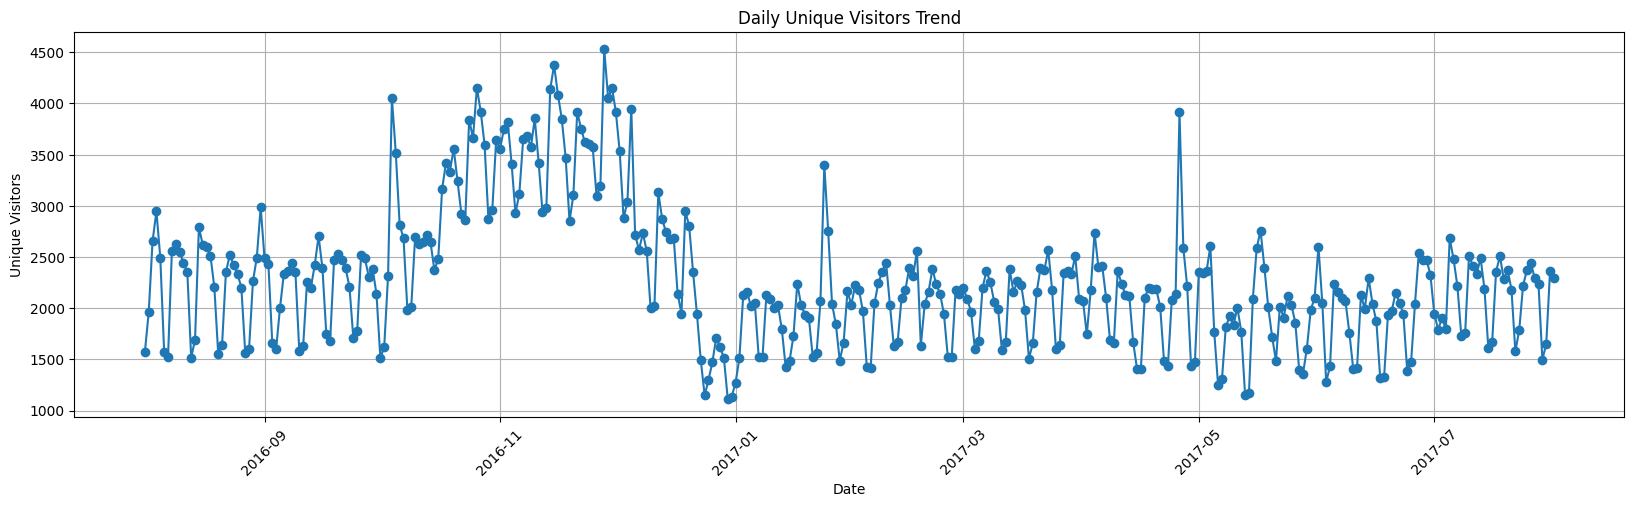

In [ ]:
# 일자별 방문 트렌드
train_df['date'] = pd.to_datetime(train_df['date'], format='%Y%m%d')    # date 형식 지정 : string -> 
daily_visits = train_df.groupby('date')['fullVisitorId'].nunique()

plt.figure(figsize=(20, 5))
plt.plot(daily_visits, marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Unique Visitors')
plt.title('Daily Unique Visitors Trend')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

- 날짜 범위 방문자 변화 가능한 원인(이벤트, 시즌성)

    2016년 10월 말 ~ 12월 방문자 급증 : Black Friday, Cyber Monday, 크리스마스 쇼핑 시즌

    2017년 1월 초 방문자 급감 : 연말 프로모션 종료, 새해 이후 소비 위축

    2017년 4월 말 방문자 급증 : 부활절 연휴, 봄 맞이 프로모션(추측)

    2017년 6월 ~ 7월 비교적 안정 : 계절적 요인 반영 (일반적인 트래픽 수준)

### 2. 요일별 / 시간대별 방문 트렌드 (Bar Plot)

/var/folders/l3/cq8y8n3s03v315zt58m2zrv80000gn/T/ipykernel_96762/1413926601.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




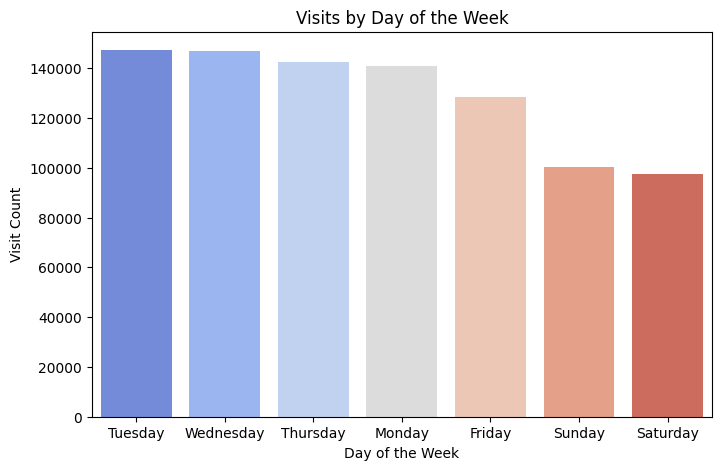

In [52]:
train_df['day_of_week'] = train_df['date'].dt.day_name()
weekday_visits = train_df['day_of_week'].value_counts()

plt.figure(figsize=(8, 5))
sns.barplot(x=weekday_visits.index, y=weekday_visits.values, palette='coolwarm')
plt.xlabel('Day of the Week')
plt.ylabel('Visit Count')
plt.title('Visits by Day of the Week')
plt.show()

### 3. 시간대별 방문 트렌드

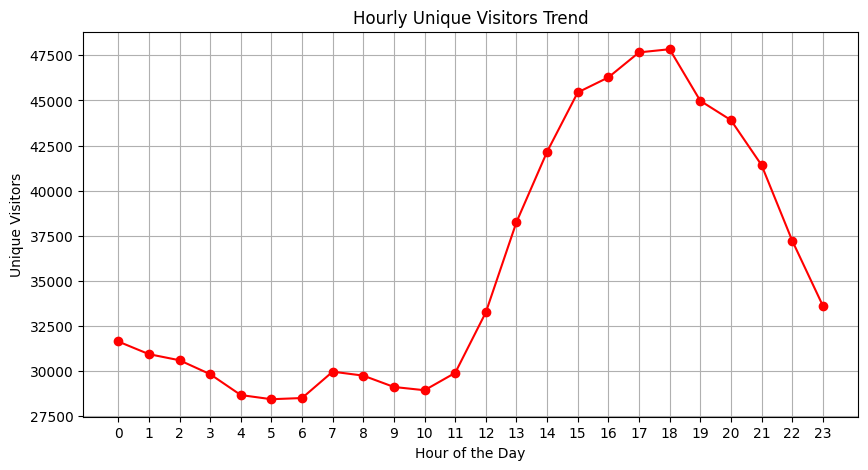

In [56]:
train_df['hour'] = train_df['visitStartTime'].apply(lambda x : pd.to_datetime(x, unit='s').hour)
hourly_visits = train_df.groupby('hour')['fullVisitorId'].nunique()

plt.figure(figsize=(10, 5))
plt.plot(hourly_visits, marker='o', linestyle='-', color='red')
plt.xlabel('Hour of the Day')
plt.ylabel('Unique Visitors')
plt.title('Hourly Unique Visitors Trend')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

- 웹사이트 방문자는 화요일, 목요일에 갖아 많고, 주말(토/일)에는 감소하는 경향을 보이며, 이는 직장인 및 업무 관련 사용자가 주요 방문층일 가능성을 시사한다.
- 오전 10시 이후 방문이 증가하다가 오후 3시에서 5시 사이에 최고치를 기록하며, 이는 점심시간 이후 업무 피크 타임과 맞물려 있다.
- 새벽(0~6시)과 저녁(19시 이후)에는 방문자가 감소하는 패턴을 보인다. 

이를 바탕으로, 주요 광고 및 마케팅은 방문이 집중되는 화,목요일과 오후 시간대(1218시)에 배치하는 것이 효과적이며, 주말과 저녁 시간대에는 리타겟팅 광고나 맞춤형 프로모션을 활용하여 방문자 감소를 보완할 필요가 있을 것으로 보인다.

### 4. 날짜별 거래 수익

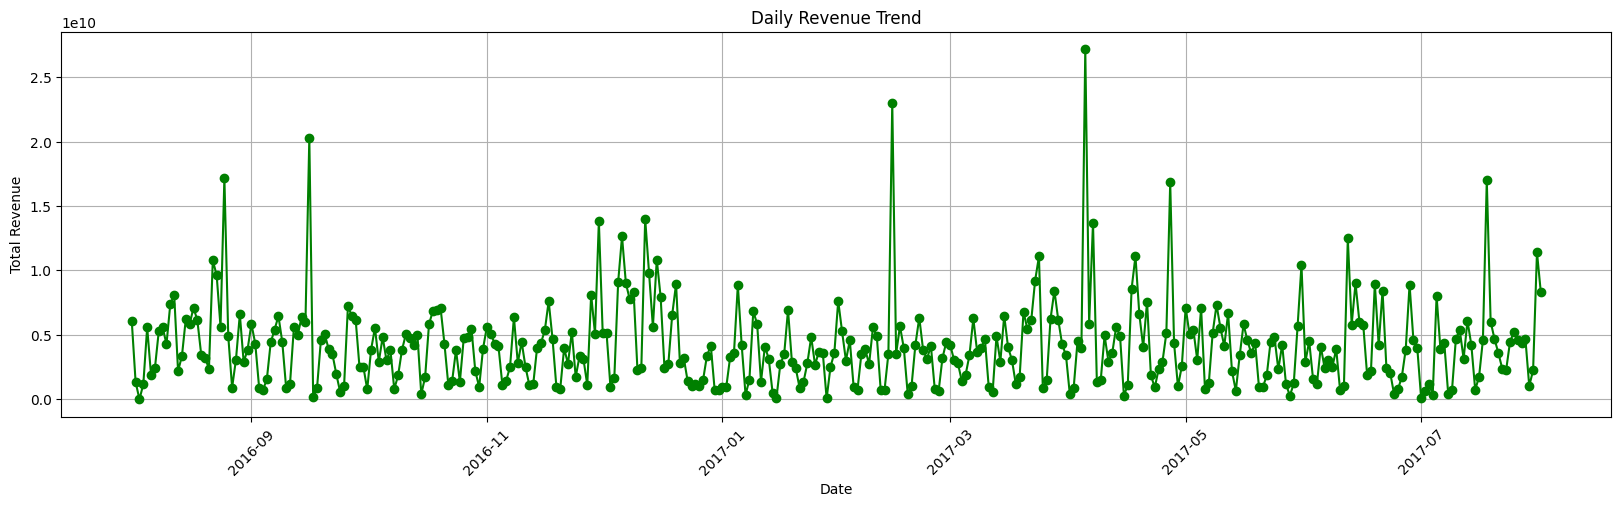

In [58]:
daily_revenue = train_df.groupby('date')['totals.transactionRevenue'].sum()

plt.figure(figsize=(20, 5))
plt.plot(daily_revenue, marker='o', linestyle='-', color='green')
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.title('Daily Revenue Trend')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

그래프 전반적으로 특정한 날에 매출이 몰려 있다. 매출은 블랙 프라이데이, 어머니의 날, 독립기념일 등 시즌별 이벤트와 밀접한 연관이 있으며, 특정 날에는 VIP 고객의 대량 구매나 단기 프로모션, 광고 캠페인 등의 영향으로 매출이 급등하는 경우가 자주 나타난다. 특히, 5월에는 어머니의 날과 시즌성 이벤트의 영향으로 매출이 크게 증가하는 경향을 보인다.

# 4. geoNetwork(지역) 그룹별 분석

### 1. 국가별 방문자 수 분석

/var/folders/l3/cq8y8n3s03v315zt58m2zrv80000gn/T/ipykernel_96762/3964341361.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




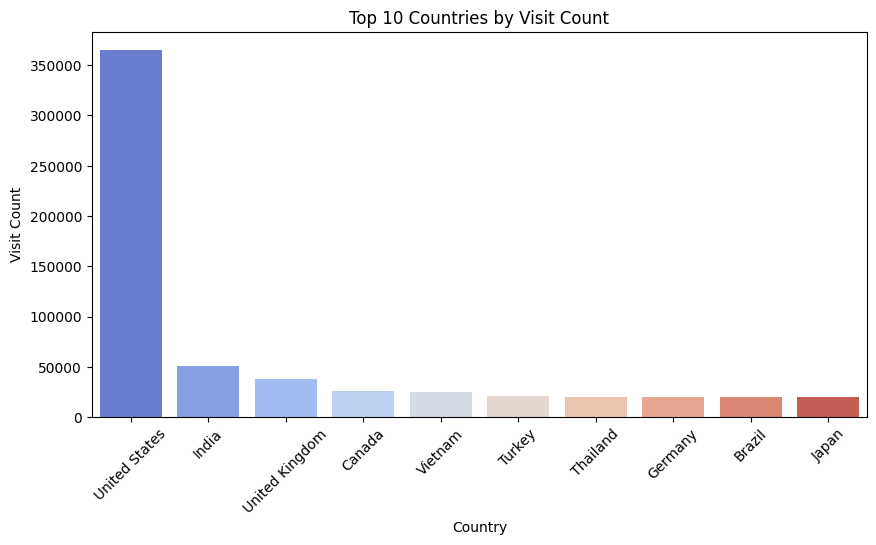

In [63]:
# 국가별 방문자 수 집계
country_visits = train_df['geoNetwork.country'].value_counts().head(10) # 사용률이 가장 높은 상위 10개국

plt.figure(figsize=(10, 5))
sns.barplot(x=country_visits.index, y=country_visits.values, palette='coolwarm', legend=False)
plt.xlabel('Country')
plt.ylabel('Visit Count')
plt.title('Top 10 Countries by Visit Count')
plt.xticks(rotation=45)
plt.show()

미국이 압도적으로 높은 방문자 수를 기록하며, 인도, 영국, 캐나다 등이 그 뒤를 잇고 있다.

### 2. 국가별 평균 매출 분석

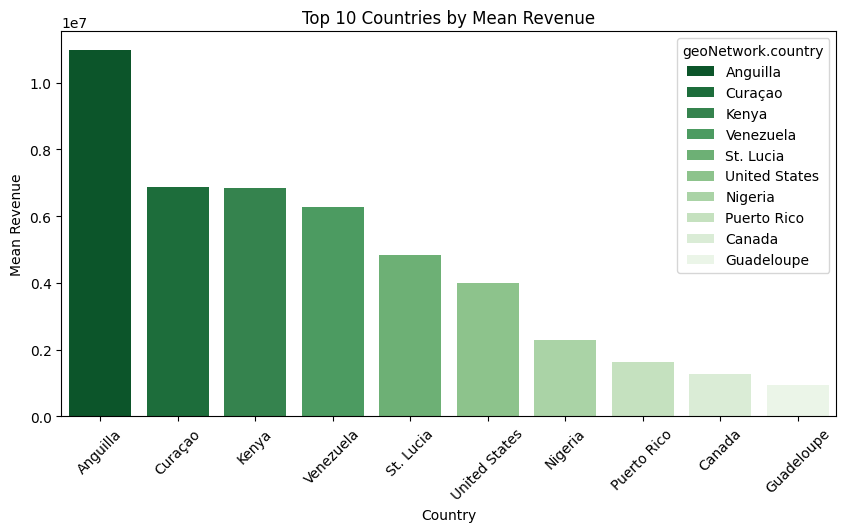

In [65]:
# 국가별 평균 거래 수익 계산
country_revenue = train_df.groupby('geoNetwork.country')['totals.transactionRevenue'].mean().sort_values(ascending=False).head(10)  # 평균 수익액 상위 10개국

plt.figure(figsize=(10, 5))
sns.barplot(x=country_revenue.index, y=country_revenue.values, hue=country_revenue.index, palette='Greens_r', legend=True)
plt.xlabel('Country')
plt.ylabel('Mean Revenue')
plt.title('Top 10 Countries by Mean Revenue')
plt.xticks(rotation=45)
plt.show()

국가별 평균 매출 분석 결과, 케냐(Kenya)와 나이지리아(Nigeria)가 가장 높은 평균 매출을 기록하며, 일본(Japan), 포르투갈(Portugal), 베네수엘라(Venezuela) 등이 뒤를 잇고 있다.

In [66]:
# 국가별 거래 수 집계 (표본 크기)
country_sample_size = train_df.groupby('geoNetwork.country')['totals.transactionRevenue'].count().sort_values(ascending=False)

# 표본 크기 출력
print(country_sample_size.head(20))

geoNetwork.country
United States     364744
India              51140
United Kingdom     37393
Canada             25869
Vietnam            24598
Turkey             20522
Thailand           20123
Germany            19980
Brazil             19783
Japan              19731
France             15832
Mexico             13225
Taiwan             12996
Australia          12698
Russia             11662
Spain              11658
Netherlands        11453
Italy              11332
Poland              9693
Indonesia           9273
Name: totals.transactionRevenue, dtype: int64


표본 크기로 짐작해보면 너무 낮은 표본 수로 인해 Mean Revenue가 과장된 것으로 보인다.

### 3. 대륙별 방문자 및 매출 기여도 분석

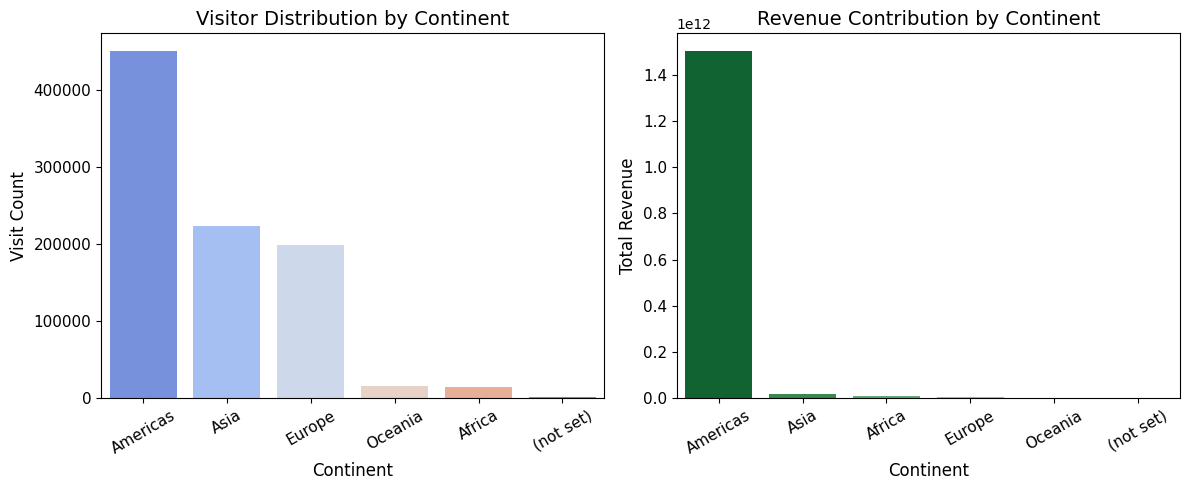

In [74]:
# 대륙별 방문자 수 집계
continent_visits = train_df['geoNetwork.continent'].value_counts()

# 대륙별 매출 집계
continent_revenue = train_df.groupby('geoNetwork.continent')['totals.transactionRevenue'].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 5))

# 대륙별 방문자 수 막대 그래프
plt.subplot(1, 2, 1)
sns.barplot(x=continent_visits.index, y=continent_visits.values, hue=continent_visits.index, palette='coolwarm', legend=False)
plt.xlabel('Continent', fontsize=12)
plt.ylabel('Visit Count', fontsize=12)
plt.title('Visitor Distribution by Continent', fontsize=14)
plt.xticks(rotation=30, fontsize=11)
plt.yticks(fontsize=11)

# 대륙별 매출 기여도 막대 그래프
plt.subplot(1, 2, 2)
sns.barplot(x=continent_revenue.index, y=continent_revenue.values, hue=continent_revenue.index, palette='Greens_r', legend=False)
plt.xlabel('Continent', fontsize=12)
plt.ylabel('Total Revenue', fontsize=12)
plt.title('Revenue Contribution by Continent', fontsize=14)
plt.xticks(rotation=30, fontsize=11)
plt.yticks(fontsize=11)

plt.tight_layout()
plt.show()

방문자 수는 Americas(미주 지역)이 가장 많으며, 그 뒤를 Asia(아시아), Europe(유럽)이 따르고 있다. 하지만 매출 기여돌르 보면 Americas가 압도적으로 높은 매출을 발생시키며, 다른 대륙은 상대적으로 매우 낮은 기여도를 보인다.

이는 미주 지역의 방문자뿐만 아니라 구매 전환율(Conversion Rate)도 높거나, 높은 금액의 구매가 발생하는 VIP 고객이 많을 가능성을 시사한다.

# 5. totals 관련 분석

totals와 관련된 컬럼들에는 세션별 유저의 행동에 대한 데이터가 담겨있다.

In [77]:
totals_columns = [col for col in train_df.columns if col.startswith('totals.')]

totals_columns

['totals.visits',
 'totals.hits',
 'totals.pageviews',
 'totals.timeOnSite',
 'totals.newVisits',
 'totals.transactions',
 'totals.transactionRevenue',
 'totals.totalTransactionRevenue',
 'totals.bounces',
 'totals.sessionQualityDim']

통계치 시각화를 위한 데이터 형변환

In [79]:
# totals 관련 df
totals_df = train_df[totals_columns].copy()

# 데이터 타입 변환 (문자열 -> 숫자)
totals_df = totals_df.apply(pd.to_numeric)
totals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 10 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   totals.visits                   903653 non-null  int64  
 1   totals.hits                     903653 non-null  int64  
 2   totals.pageviews                903553 non-null  float64
 3   totals.timeOnSite               451894 non-null  float64
 4   totals.newVisits                703060 non-null  float64
 5   totals.transactions             11552 non-null   float64
 6   totals.transactionRevenue       903653 non-null  float64
 7   totals.totalTransactionRevenue  11515 non-null   float64
 8   totals.bounces                  450630 non-null  float64
 9   totals.sessionQualityDim        68379 non-null   float64
dtypes: float64(8), int64(2)
memory usage: 68.9 MB


timeOnSite, newVisits, transactions, transactionRevenue, totalTransactionRevenue, bounces, sessionQualityDim에는 결측치가 존재하므로 이를 0으로 대체

In [81]:
# 결측값 처리 (0으로 대체)
totals_df.fillna(0, inplace=True)

시각화 : 방문 수, 페이지뷰, 트랜잭션, 매출 비교

/Users/taeheon/miniforge3/envs/customer/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning:

invalid value encountered in subtract



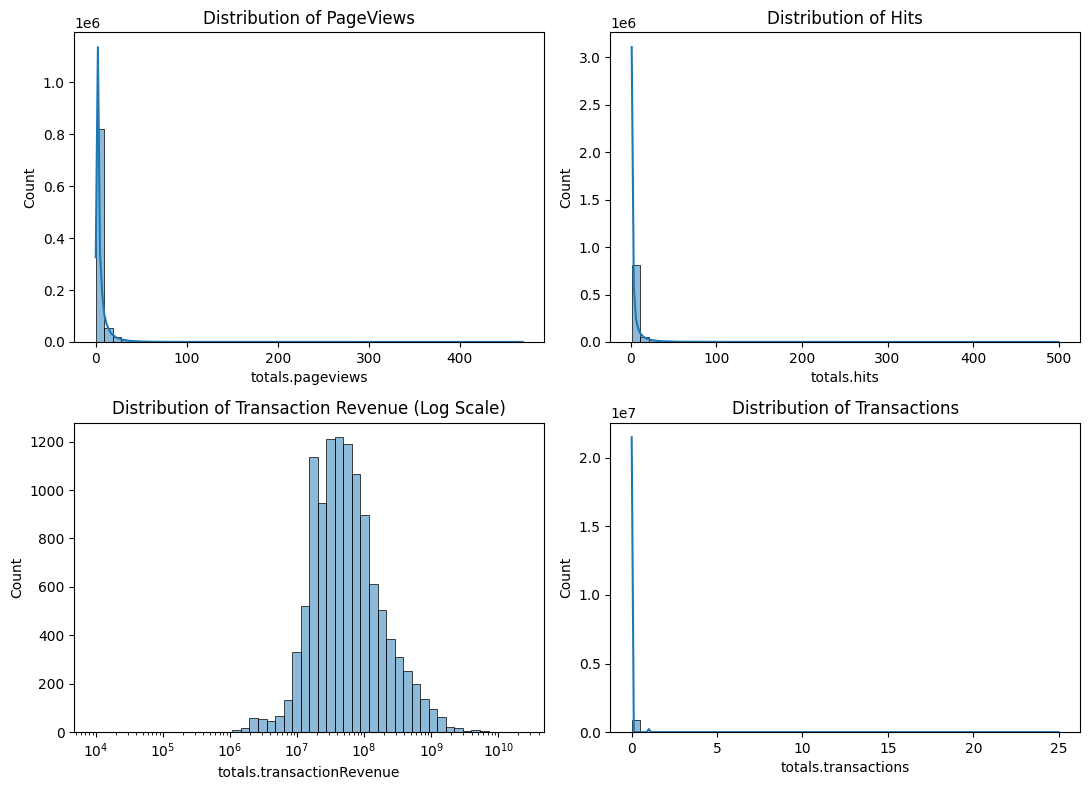

In [85]:
fig, axes = plt.subplots(2, 2, figsize=(11, 8))

# 페이지뷰 분포
if 'totals.pageviews' in totals_df.columns :
    sns.histplot(totals_df['totals.pageviews'], bins=50, ax=axes[0, 0], kde=True)
    axes[0, 0].set_title("Distribution of PageViews")
else :
    axes[0, 0].set_visible(False)

# 히트 수 (사이트 내 인터랙션) 분포
if 'totals.hits' in totals_df.columns :
    sns.histplot(totals_df['totals.hits'], bins=50, ax=axes[0, 1], kde=True)
    axes[0, 1].set_title("Distribution of Hits")
else :
    axes[0, 1].set_visible(False)

# 거래 발생 수 분포 (로그 스케일 적용)
if 'totals.transactionRevenue' in totals_df.columns :
    sns.histplot(totals_df['totals.transactionRevenue'], bins=50, ax=axes[1, 0], kde=True, log_scale=True)
    axes[1, 0].set_title("Distribution of Transaction Revenue (Log Scale)")
else :
    axes[1, 0].set_visible(False)

# 전체 트랜잭션 분포
if 'totals.transactions' in totals_df.columns :
    sns.histplot(totals_df['totals.transactions'], bins=50, ax=axes[1, 1], kde=True)
    axes[1, 1].set_title("Distribution of Transactions")
else :
    axes[1, 1].set_visible(False)

plt.tight_layout()
plt.show()

1. 첫 번째 그래프는 페이지뷰(totals.pageviews)의 분포를 보여주며, 대부분의 방문자가 적은 페이지뷰를 기록하고 일부 방문자가 다수의 페이지를 조회하는 극단적인 분포를 보인다.

2. 두 번째 그래프는 사이트 내 사용자 활동(totals.hits)을 나타내며, 마찬가지로 대부분의 사용자들이 적은 상호작용을 하고 소수의 사용자만 높은 활동량을 보이는 편향된 분포를 나타낸다.

3. 세 번째 그래프는 거래 수익(totals.transactionRevenue)의 로그 스케일 분포로, 대다수의 고객이 매출을 발생시키지 않으며, 일부 VIP 고객이 높은 수익을 창출하는 경향을 보인다.

4. 네 번째 그래프는 전자상거래수(totals.transactions)의 분포로, 극히 일부 사용자만이 실제 거래를 진행했다는 것을 알 수 있다.

즉, 대부분의 고객은 낮은 참여도와 거래수를 보이지만, 특정 고객층이 페이지뷰, 활동량, 매출에 있어 중요한 역할을 한다는 점에서 VIP 고객에 대한 집중적인 분석과 타겟 마케팅이 필요함을 시사한다.

# 6. trafficSource(유입경로) 그룹별 분석

In [88]:
# trafficSource 관련 컬럼 확인
traffic_columns = [col for col in train_df.columns if col.startswith('trafficSource')]
traffic_df = train_df[traffic_columns]


# 주요 컬럼별 데이터 확인 (캠페인, 소스, 미디어)
traffic_summary = traffic_df.describe(include='all')

traffic_summary

,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.referralPath,trafficSource.keyword,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.campaignCode
count,903653,903653,903653,274005,903653,330941,241905,10946,21460,21460,21561,21460,21460,1
unique,8,275,7,1,1,1475,2717,44,8,2,17774,2,1,1
top,(not set),(direct),(none),True,not available in demo dataset,/,(not provided),Google Merchandise Collection,1,Top,Cj0KEQjwmIrJBRCRmJ_x7KDo-9oBEiQAuUPKMufMpuG3Zd...,Google Search,False,11251kjhkvahf
freq,875599,371469,371467,274005,903653,75523,222542,5122,21362,20956,70,21453,21460,1


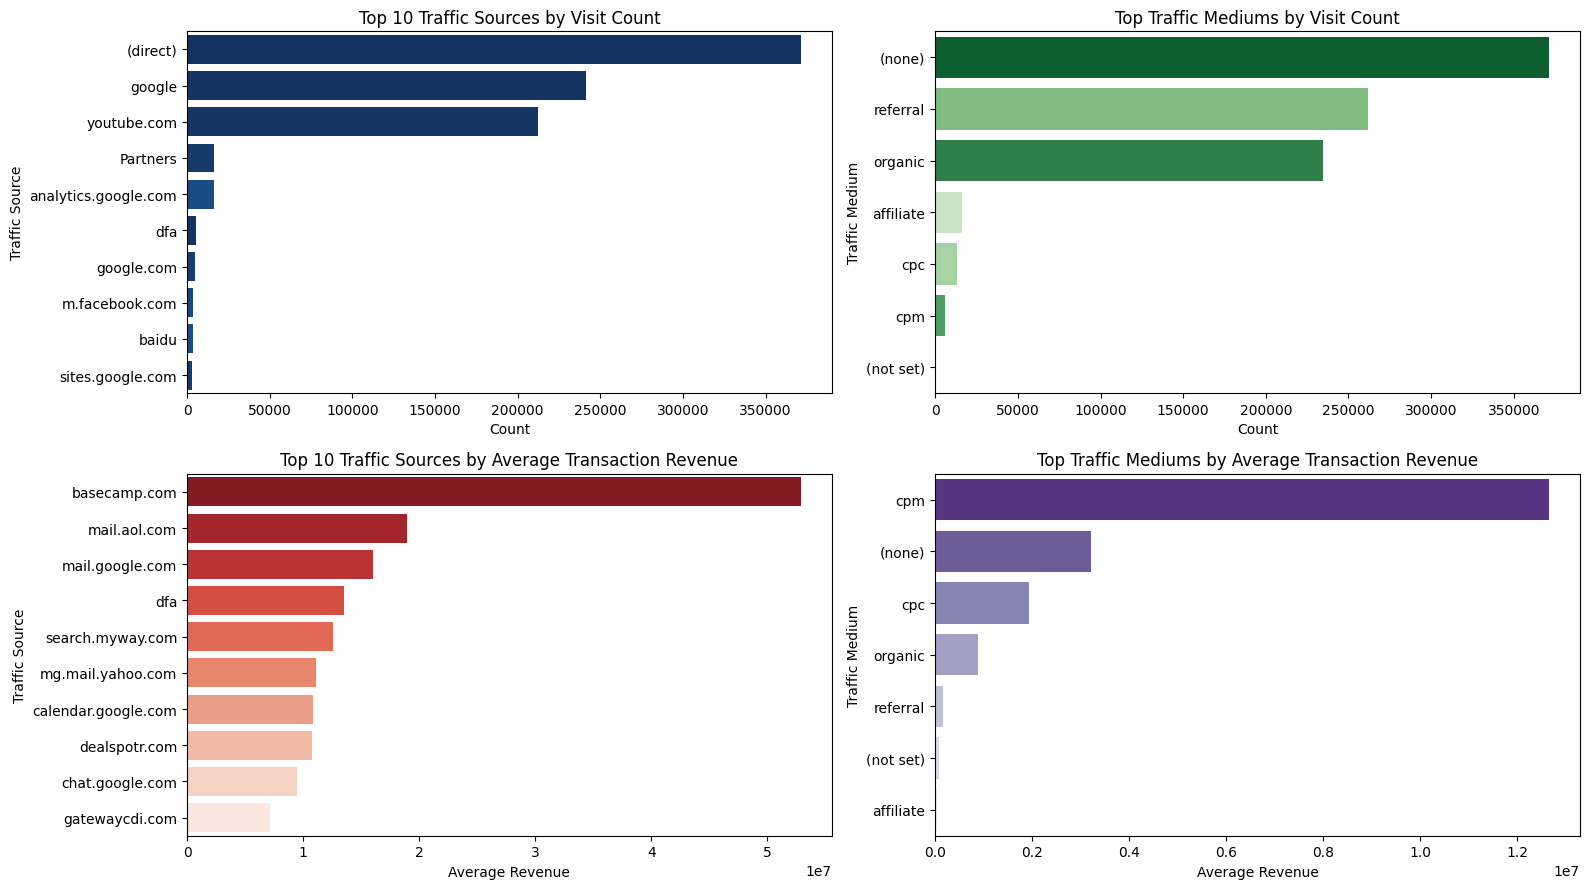

In [90]:
# trafficSource 시각화
fig, axes = plt.subplots(2, 2, figsize=(16, 9))

# trafficSource.source별 방문 수 시각화
sns.countplot(y=train_df['trafficSource.source'],
              order=train_df['trafficSource.source'].value_counts().index[:10],
              hue=train_df['trafficSource.source'],
              legend=False,
              palette="Blues_r",
              ax=axes[0,0])
axes[0, 0].set_title("Top 10 Traffic Sources by Visit Count")
axes[0, 0].set_xlabel("Count")
axes[0, 0].set_ylabel("Traffic Source")

# trafficSource.medium별 방문 수 시각화
sns.countplot(y=train_df['trafficSource.medium'],
              order=train_df['trafficSource.medium'].value_counts().index[:10],
              hue=train_df['trafficSource.medium'],
              legend=False,
              palette='Greens_r',
              ax=axes[0,1])
axes[0, 1].set_title("Top Traffic Mediums by Visit Count")
axes[0, 1].set_xlabel("Count")
axes[0, 1].set_ylabel("Traffic Medium")

# trafficSource.source별 평균 거래 수익 시각화
avg_revenue_by_source = train_df.groupby('trafficSource.source')['totals.transactionRevenue'].mean().sort_values(ascending=False)[:10]
sns.barplot(x=avg_revenue_by_source.values,
            y=avg_revenue_by_source.index,
            hue=avg_revenue_by_source.index,
            legend=False,
            palette='Reds_r',
            ax=axes[1, 0])
axes[1, 0].set_title("Top 10 Traffic Sources by Average Transaction Revenue")
axes[1, 0].set_xlabel("Average Revenue")
axes[1, 0].set_ylabel("Traffic Source")

# trafficSource.medium별 평균 거래 수익 시각화
avg_revenue_by_medium = train_df.groupby('trafficSource.medium')['totals.transactionRevenue'].mean().sort_values(ascending=False)[:10]
sns.barplot(x=avg_revenue_by_medium.values,
            y=avg_revenue_by_medium.index,
            hue=avg_revenue_by_medium.index,
            legend=False,
            palette='Purples_r',
            ax=axes[1, 1])
axes[1, 1].set_title("Top Traffic Mediums by Average Transaction Revenue")
axes[1, 1].set_xlabel("Average Revenue")
axes[1, 1].set_ylabel("Traffic Medium")

plt.tight_layout()
plt.show()

트래픽 소스와 트래픽 미디어별 방문 수 및 평균 거래 수익을 분석한 결과, Google과 YouTube가 가장 많은 방문을 유도하며, 직접 방문(Direct)과 추천(Referral) 트래픽도 중요한 비중을 차지하고 있다.

방문 수 기준으로는 'organic(자연 검색)', 'referral(추천)', 'none(직접 입력)'이 주요 트래픽 유입 경로로 나타났다.

평균 거래 수익을 보면 'basecamp.com', 'mail.aol.com', 'mail.google.com', 'dfa' 트래픽이 높은 수익을 발생시키며, 특히 'cpm(노출 기반 광고)'과 'none'이 높은 거래 수익을 보였다.

이를 통해 **방문 수와 매출이 반드시 비례하는 것은 아니며, 특정 유입 경로(이메일, 직접 방문, 특정 광고 채널)가 높은 구매 전환율을 보일 가능성**이 높아 보인다.

# 7. 사용자 수익 예측 모델을 위한 추가 EDA

### (1) 고객군별 분석 (VIP vs 일반 고객)
- 수익 기여도가 노은 상위 % 고객 분석
- VIP 고객의 특징(방문 빈도, 유입 경로, 디바이스 유형 등) 비교

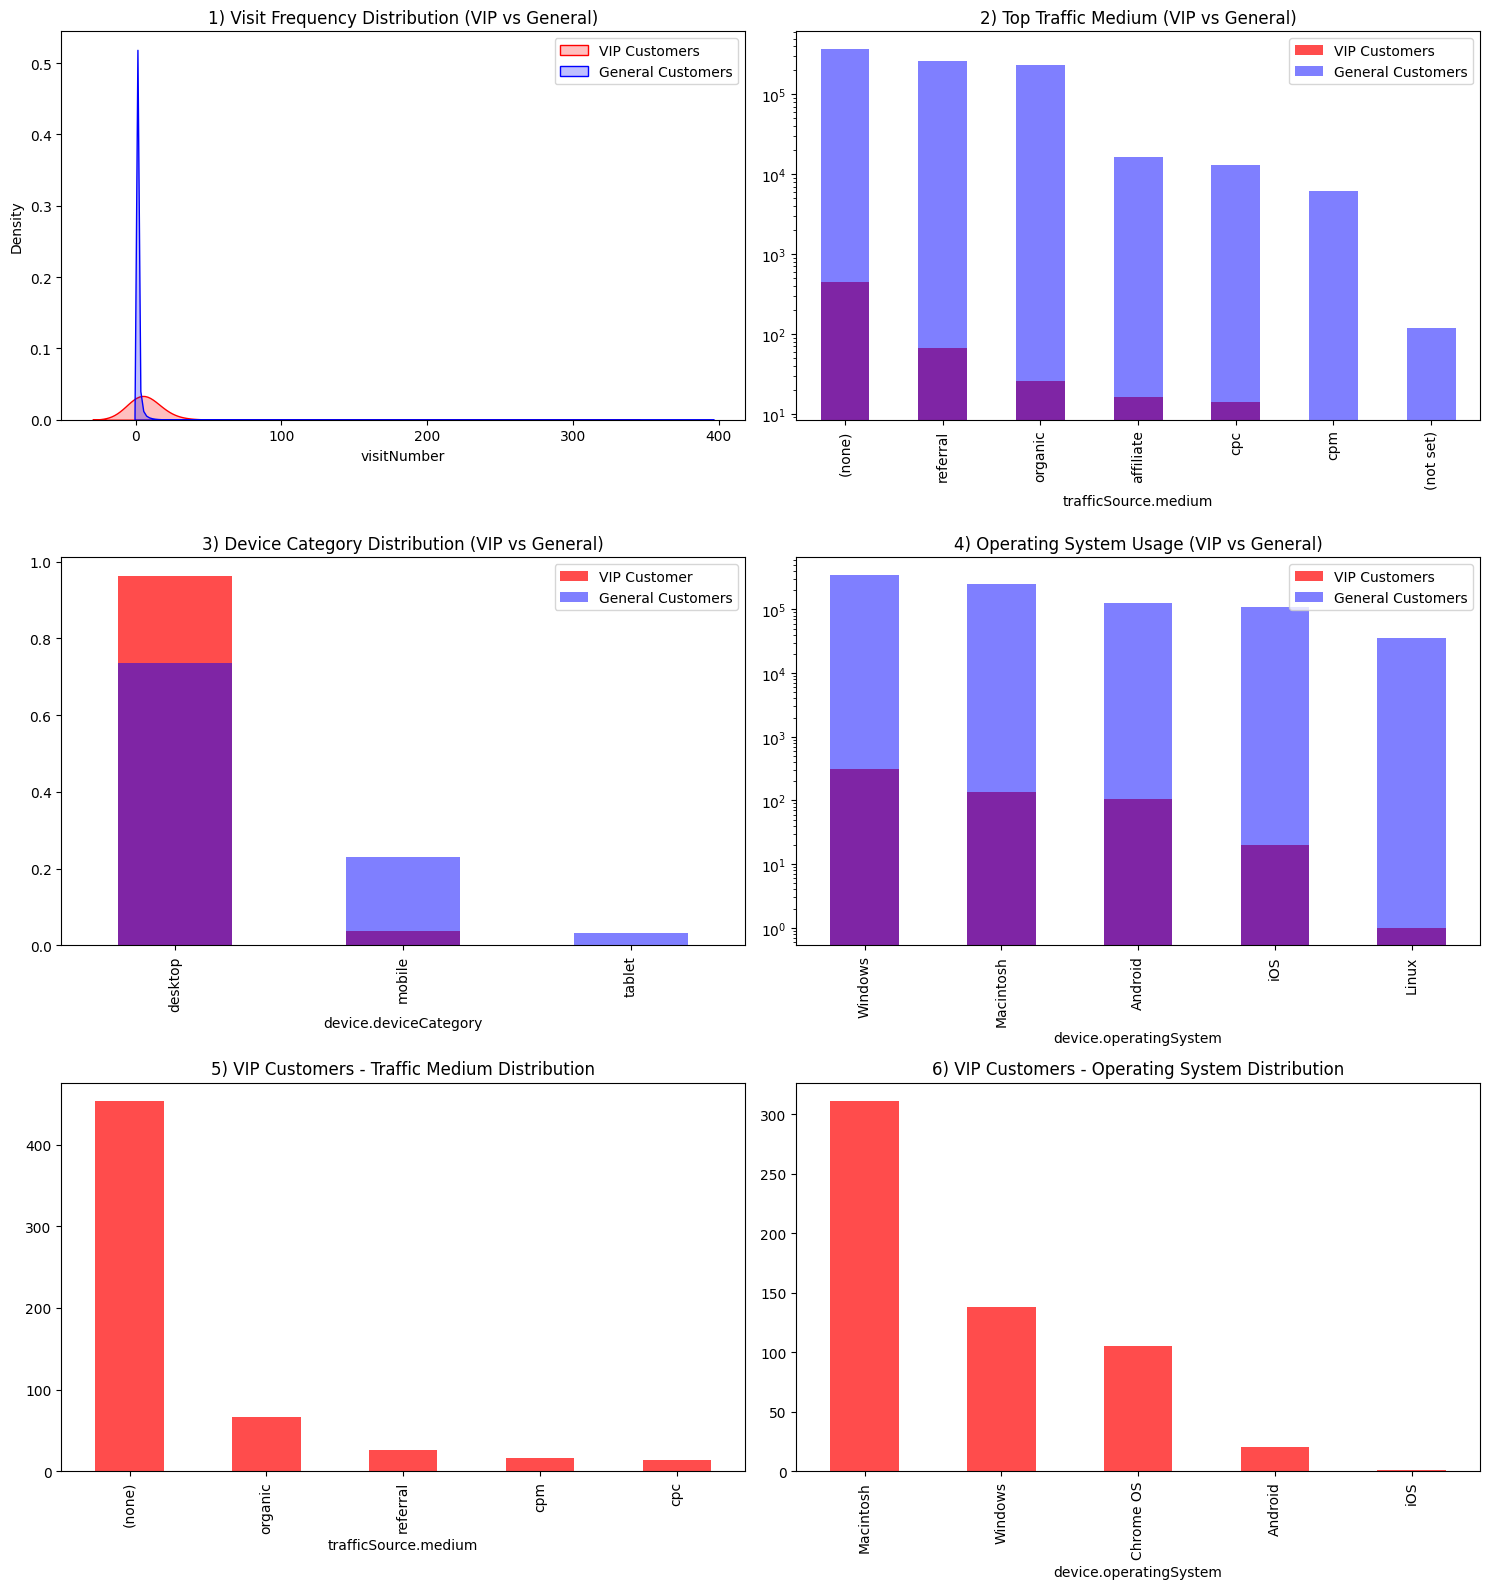

In [99]:
# 매출이 발생한 고객만 필터링
revenue_customers = train_df[train_df['totals.transactionRevenue'] > 0]

# 상위 5% 기준으로 VIP 고객 선정
vip_threshold = revenue_customers['totals.transactionRevenue'].quantile(0.95)

# VIP 고객과 일반 고객 나누기
train_df['is_vip'] = train_df['totals.transactionRevenue'] >= vip_threshold

vip_df = train_df[train_df["is_vip"]]
general_df = train_df[~train_df["is_vip"]]

# 시각화
fig, axes = plt.subplots(3, 2, figsize=(15, 16))

# 방문 빈도 비교
sns.kdeplot(vip_df['visitNumber'], label="VIP Customers", ax=axes[0, 0], fill=True, color="red")
sns.kdeplot(general_df["visitNumber"], label="General Customers", ax=axes[0, 0], fill=True, color="blue")
axes[0, 0].set_title("1) Visit Frequency Distribution (VIP vs General)")
axes[0, 0].legend()

# 유입 경로 비교 (Medium) - 로그 스케일 적용
if not vip_df["trafficSource.medium"].empty and not general_df["trafficSource.medium"].empty :
    vip_medium = vip_df["trafficSource.medium"].value_counts().head(10)
    general_medium = general_df["trafficSource.medium"].value_counts().head(10)

    vip_medium.plot(kind="bar", ax=axes[0, 1], color="red", alpha=0.7, label="VIP Customers")
    general_medium.plot(kind="bar", ax=axes[0, 1], color="blue", alpha=0.5, label="General Customers")
    axes[0, 1].set_title("2) Top Traffic Medium (VIP vs General)")
    axes[0, 1].legend()
    axes[0, 1].set_yscale("log")    # 로그 스케일 적용
else :
    axes[0, 1].text(0.5, 0.5, "No Data Available", fontsize=12, ha="center")
    axes[0, 1].set_title("Top Traffic Medium (VIP vs General)")

# 디바이스 유형별 비교 (deviceCategory) - 빈 데이터 예외 처리 추가
if not vip_df["device.deviceCategory"].empty and not general_df["device.deviceCategory"].empty :
    vip_device = vip_df["device.deviceCategory"].value_counts(normalize=True)
    general_device = general_df["device.deviceCategory"].value_counts(normalize=True)

    vip_device.plot(kind="bar", ax=axes[1, 0], color="red", alpha=0.7, label="VIP Customer")
    general_device.plot(kind="bar", ax=axes[1, 0], color="blue", alpha=0.5, label="General Customers")
    axes[1, 0].set_title("3) Device Category Distribution (VIP vs General)")
    axes[1, 0].legend()
else :
    axes[1, 0].text(0.5, 0.5, "No Data Available", fontsize=12, ha="center")
    axes[1, 0].set_title("Device Category Distribution (VIP vs General)")

# 운영 체제 비교 (OS)
if not vip_df["device.operatingSystem"].empty and not general_df["device.operatingSystem"].empty :
    vip_os = vip_df["device.operatingSystem"].value_counts().head(5)
    general_os = general_df["device.operatingSystem"].value_counts().head(5)

    vip_os.plot(kind="bar", ax=axes[1, 1], color="red", alpha=0.7, label="VIP Customers")
    general_os.plot(kind="bar", ax=axes[1, 1], color="blue", alpha=0.5, label="General Customers")
    axes[1, 1].set_title("4) Operating System Usage (VIP vs General)")
    axes[1, 1].legend()
    axes[1, 1].set_yscale("log")
else :
    axes[1, 1].text(0.5, 0.5, "No Data Available", fontsize=12, ha="center")
    axes[1, 1].set_title("Operating System Usage (VIP vs General)")

# VIP 고객 데이터만 별도 분석(유입 경로, OS)
vip_medium.plot(kind="bar", ax=axes[2, 0], color="red", alpha=0.7)
axes[2, 0].set_title("5) VIP Customers - Traffic Medium Distribution")

vip_os.plot(kind="bar", ax=axes[2, 1], color="red", alpha=0.7)
axes[2, 1].set_title("6) VIP Customers - Operating System Distribution")

plt.tight_layout()
plt.show()

VIP 고객과 일반 고객의 방문 빈도, 유입 경로, 디바이스 사용 패턴이 뚜렷이 구분된다.

첫 번째 그래프에서 VIP 고객의 방문 빈도가 일반 고객보다 높고 분포가 다르게 나타나, 충성도가 높을 가능성을 시사한다.

또한 두 번째와 다섯 번째 그래프를 보면 일반 고객과 VIP 고객 모두 "organic" 및 "referral" 트래픽을 통해 유입되지만, VIP 고객은 "(none)" 트래픽 비율이 높아 직접 웹사이트를 방문하거나 즐겨찾기를 통해 유입될 가능성이 크다. 이는 VIP 고객이 브랜드에 대한 충성도가 높음을 의미한다.

세 번째 그래프에서는 VIP 고객이 데스크탑을 주로 사용하며 모바일 사용 비율이 낮은 특징을 보인다는 것을 알 수 있다.

네 번째와 여섯 번째 그래프에서는 VIP 고객이 주로 Macintosh를 사용하는 반면, 일반 고객은 Windows 사용 비율이 높아 보다 대중적인 소비자층을 포함할 가능성이 크다. 이러한 차이를 고려할 때, VIP 고객 타겟팅을 위해서는 데스크탑 UX 최적화와 직접 방문 유입을 유도하는 마케팅 전략이 효과적일 것으로 보인다.

### (2) 유입 채널별 전환율 분석 (trafficSource.medium, trafficSource.campaign)
- 광고 캠페인, 유입 채널별 평균 거래 수익 비교
- 유기적 유입(organic), 직접 방문(Direct), 광고 유입(cpc) 간의 차이 분석

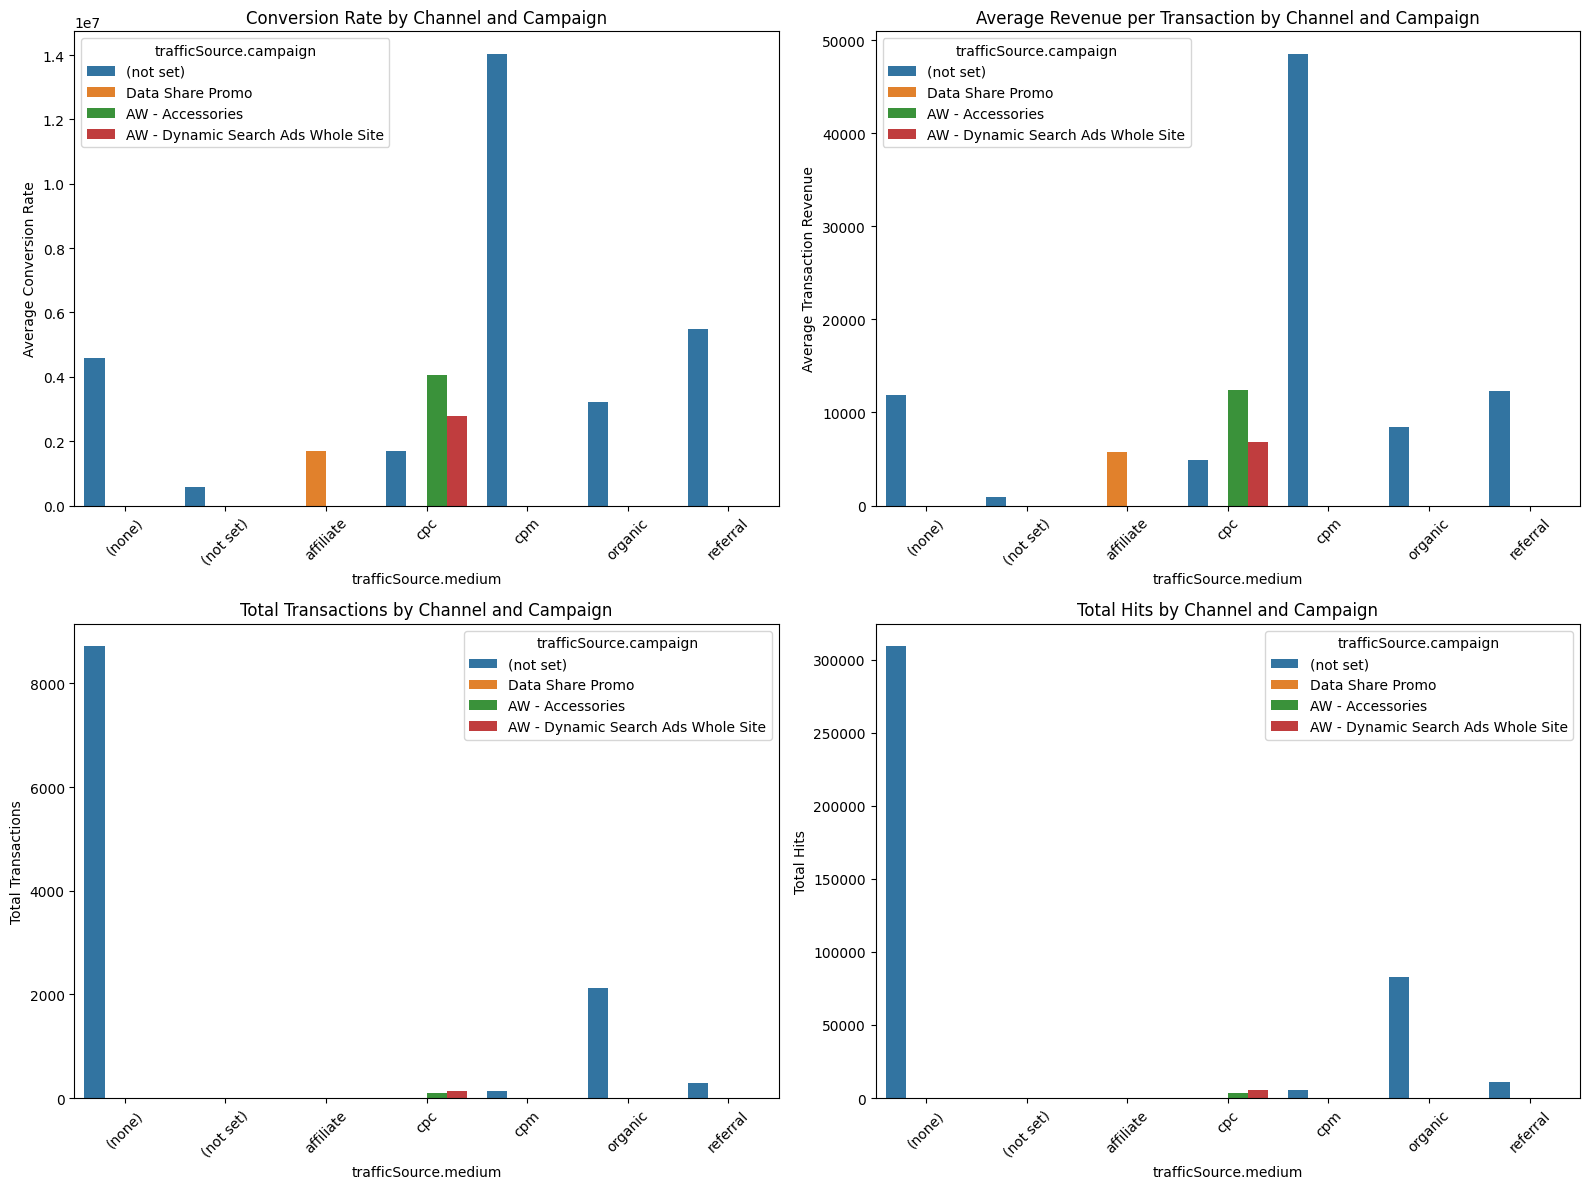

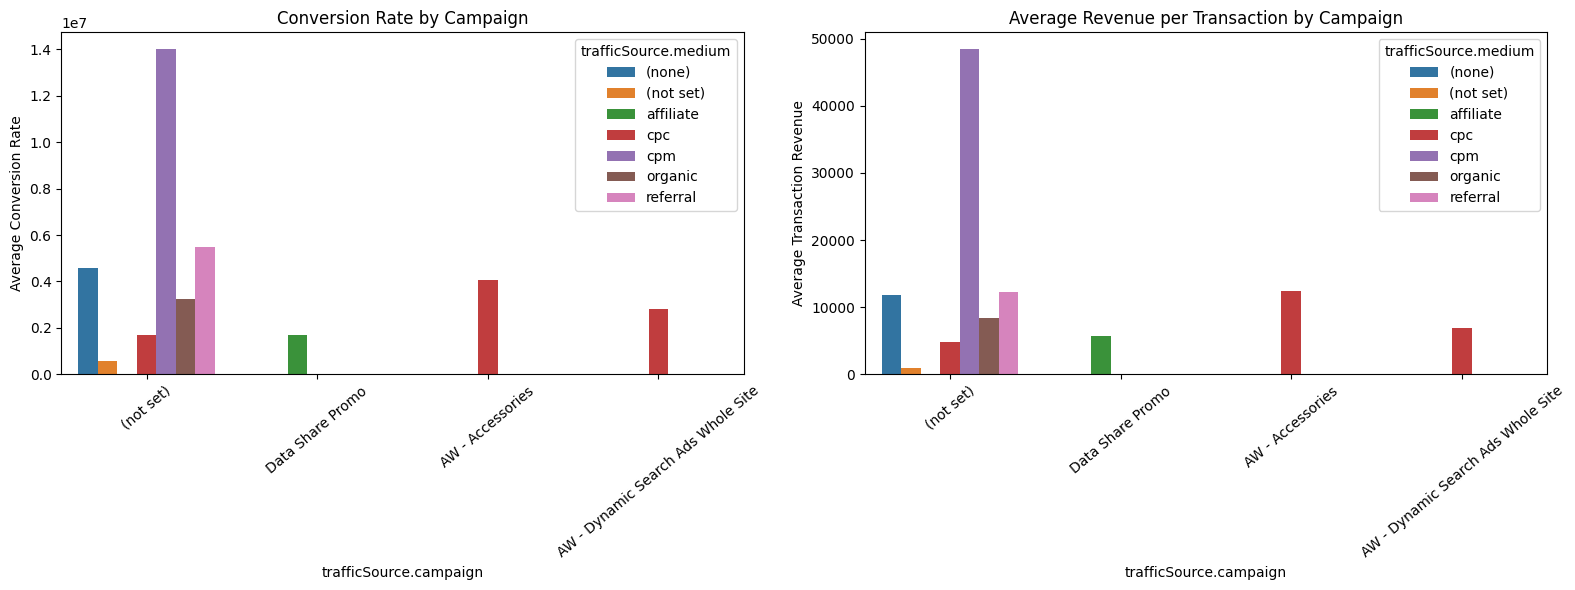

In [107]:
# 필요한 컬럼 선택
df = train_df[['trafficSource.medium', 'trafficSource.campaign', 'totals.hits', 'totals.transactionRevenue']].copy()

# 결측치 처리
df = df.dropna()

# 데이터 타입 변환 (문자열 → 숫자)
df['totals.hits'] = pd.to_numeric(df['totals.hits'], errors='coerce')
df['totals.transactionRevenue'] = pd.to_numeric(df['totals.transactionRevenue'], errors='coerce')

# 결측값을 0으로 대체
df.fillna(0, inplace=True)

# 거래가 발생한 데이터만 필터링
df = df[df['totals.transactionRevenue'] > 0]

# 전환율 및 평균 거래 수익 계산
df['conversion_rate'] = df['totals.transactionRevenue'] / df['totals.hits']
df['avg_revenue'] = df['totals.transactionRevenue'] / df['totals.transactionRevenue'].count()

# 그룹별 요약 통계 계산
summary = df.groupby(['trafficSource.medium', 'trafficSource.campaign']).agg(
    total_hits=('totals.hits', 'sum'),
    total_transactions=('totals.transactionRevenue', 'count'),
    avg_conversion_rate=('conversion_rate', 'mean'),
    avg_transaction_revenue=('avg_revenue', 'mean')
).reset_index()

# 데이터 시각화
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.barplot(data=summary, x='trafficSource.medium', y='avg_conversion_rate', hue='trafficSource.campaign', ax=axes[0, 0])
axes[0, 0].set_title('Conversion Rate by Channel and Campaign')
axes[0, 0].set_ylabel('Average Conversion Rate')
axes[0, 0].tick_params(axis='x', rotation=45)

sns.barplot(data=summary, x='trafficSource.medium', y='avg_transaction_revenue', hue='trafficSource.campaign', ax=axes[0, 1])
axes[0, 1].set_title('Average Revenue per Transaction by Channel and Campaign')
axes[0, 1].set_ylabel('Average Transaction Revenue')
axes[0, 1].tick_params(axis='x', rotation=45)

sns.barplot(data=summary, x='trafficSource.medium', y='total_transactions', hue='trafficSource.campaign', ax=axes[1, 0])
axes[1, 0].set_title('Total Transactions by Channel and Campaign')
axes[1, 0].set_ylabel('Total Transactions')
axes[1, 0].tick_params(axis='x', rotation=45)

sns.barplot(data=summary, x='trafficSource.medium', y='total_hits', hue='trafficSource.campaign', ax=axes[1, 1])
axes[1, 1].set_title('Total Hits by Channel and Campaign')
axes[1, 1].set_ylabel('Total Hits')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 캠페인별 분석
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(data=summary, x='trafficSource.campaign', y='avg_conversion_rate', hue='trafficSource.medium', ax=axes[0])
axes[0].set_title('Conversion Rate by Campaign')
axes[0].set_ylabel('Average Conversion Rate')
axes[0].tick_params(axis='x', rotation=40)

sns.barplot(data=summary, x='trafficSource.campaign', y='avg_transaction_revenue', hue='trafficSource.medium', ax=axes[1])
axes[1].set_title('Average Revenue per Transaction by Campaign')
axes[1].set_ylabel('Average Transaction Revenue')
axes[1].tick_params(axis='x', rotation=40)

plt.tight_layout()
plt.show()

각 그래프는 **트래픽 소스(trafficSource.medium)** 와 **캠페인(trafficSource.campaign)** 별 전환율, 총 거래 수, 평균 거래 수익 등을 비교하여 마케팅 성과를 분석함(캠페인 이름들은 내부에서 사용하는 캠패인별 트래픽 소스를 나타내는 필드. 이름인지라 의미에 대해서는 생각 안해도 될듯).  

---

#### 1. 트래픽 소스 및 캠페인별 전환율 (Conversion Rate)  
첫 번째 그래프에서는 **각 트래픽 소스와 캠페인별 전환율**을 보여줌.  
특정 트래픽 소스(예: **organic, referral** 등)는 높은 전환율을 기록하는 반면, 일부 **유료 광고 채널**은 상대적으로 낮은 전환율을 보일 수 있음.  

---

#### 2. 거래당 평균 수익 (Average Revenue per Transaction)  
두 번째 그래프에서는 **각 채널과 캠페인의 거래당 평균 수익**을 나타냄.  
특정 유입 경로(예: **cpc, affiliate** 등)는 **높은 단가의 구매**를 유도하는 경향을 보일 수 있음.  

---

#### 3. 총 거래 수 (Total Transactions)  
세 번째 그래프는 **총 거래 수**를 분석함.  
특정 트래픽 소스(예: **organic, referral** 등)는 많은 거래를 발생시키는 반면, 일부 **유료 광고 캠페인**은 거래량이 적을 수 있음.  

---

#### 4. 총 세션 수 (Total Sessions)  
네 번째 그래프는 **총 세션 수**를 나타냄.  
이를 통해 **방문량이 높은 트래픽 소스가 반드시 높은 매출을 보장하지 않는다는 점**을 확인할 수 있음.  

---

#### 5. 캠페인별 전환율과 평균 거래 수익 비교  
마지막 두 개의 그래프는 **캠페인별 전환율과 평균 거래 수익을 트래픽 소스와 함께 비교**함.  
이를 통해 다음과 같은 인사이트를 도출할 수 있음.  
- 특정 캠페인이 **전환율은 낮지만 높은 수익을 창출**하는지  
- 특정 캠페인이 **많은 방문자를 유도하지만 수익 기여도가 낮은지**
---

### (3) 시간대별 수익 패턴 분석 (date, hour)
- 특정 요일, 특정 시간대에 수익이 증가하는지 확인
- 시즌성 이벤트(블랙 프라이데이, 명절, 세일 기간 등)에 따른 매출 변화

/var/folders/l3/cq8y8n3s03v315zt58m2zrv80000gn/T/ipykernel_96762/1460111682.py:38: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



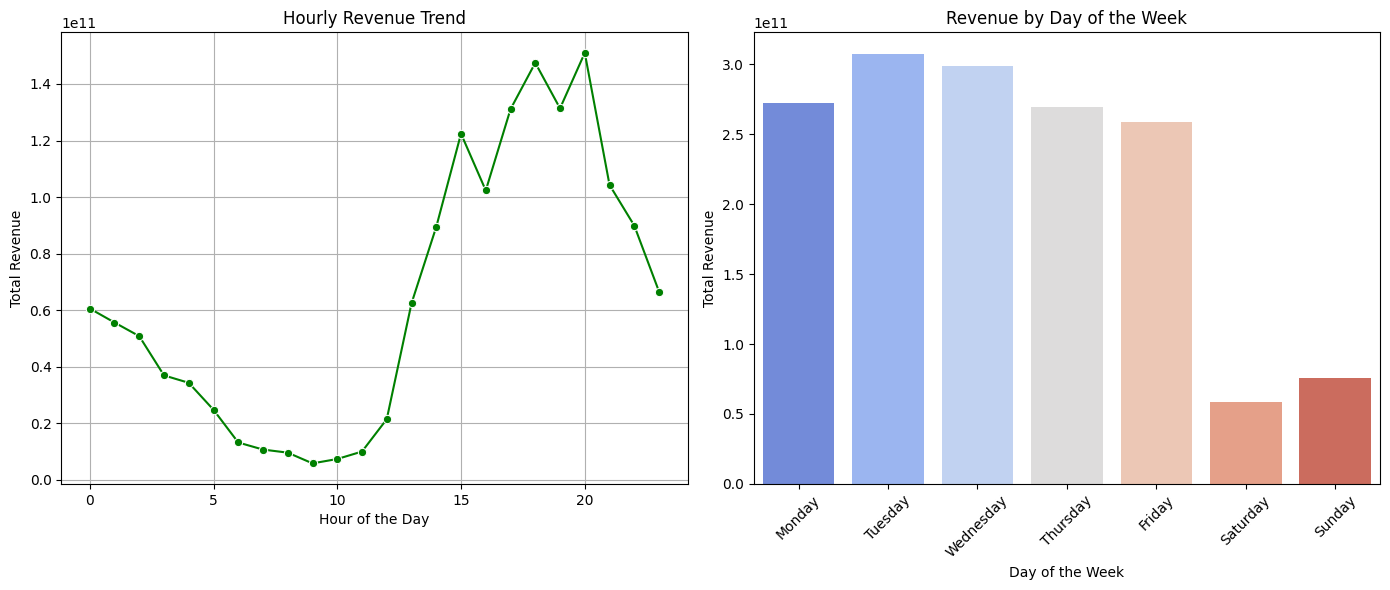

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 'date'와 'hour' 기반 수익 데이터 필터링
if "date" in train_df.columns and "hour" in train_df.columns and "totals.transactionRevenue" in train_df.columns:
    # 날짜 변환
    train_df["date"] = pd.to_datetime(train_df["date"], format="%Y%m%d")

    # 요일 추가
    train_df["day_of_week"] = train_df["date"].dt.day_name()

    # 시간대별 수익 분석
    hourly_revenue = train_df.groupby("hour")["totals.transactionRevenue"].sum()

    # 요일별 수익 분석
    daily_revenue = train_df.groupby("day_of_week")["totals.transactionRevenue"].sum()

    # 요일 순서 정렬
    day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    daily_revenue = daily_revenue.reindex(day_order)

    # 시각화
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # 시간대별 수익
    sns.lineplot(x=hourly_revenue.index, y=hourly_revenue.values, ax=axes[0], marker="o", color="green")
    axes[0].set_title("Hourly Revenue Trend")
    axes[0].set_xlabel("Hour of the Day")
    axes[0].set_ylabel("Total Revenue")
    axes[0].grid(True)

    # 요일별 수익
    sns.barplot(x=daily_revenue.index, y=daily_revenue.values, ax=axes[1], hue=daily_revenue.index, palette="coolwarm", legend=False)
    axes[1].set_title("Revenue by Day of the Week")
    axes[1].set_xlabel("Day of the Week")
    axes[1].set_ylabel("Total Revenue")
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

    plt.tight_layout()
    plt.show()
else:
    print("Required columns are missing in the dataset.")


두 그래프는 시간대별 방문자 수와 매출 간의 차이를 보여준다.

첫 번째 그래프(녹색)는 시간대별 총 매출을 나타내며, 새벽(0시-6시)에는 매출이 낮고, 오후 3시 이후 급격히 증가해 오후 6~7시경 최고점을 기록한 후 다시 감소하는 패턴을 보인다. 이는 퇴근 후 구매 활동이 홀발해지는 경향을 반영할 가능성이 크다.

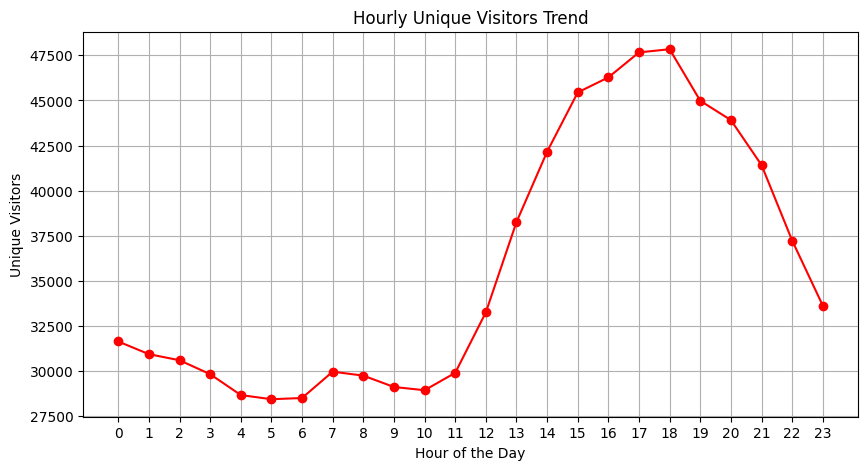

반면, 두 번째 그래프(빨간색)는 시간대별 방문자수를 나타내는데, 방문자는 새벽에 적고 오전부터 증가해 오후 5~6시경 최대치를 기록한 후 점차 감소하는 패턴을 보인다.

흥미로운 점은 방문자가 가장 많은 시간(빨간색 그래프, 17~18시)과 매출이 가장 높은 시간(녹색 그래프, 15~18시)이 다소 차이가 난다는 것이다. 즉, 단순 방문자 수 증가가 매출 증가로 직결되지 않으며, 오후 3~6시 방문 고객의 구매 전환율이 더 높을 가능성이 있다.

이를 바탕으로, 오후 3~6시 집중 프로모션 운영, 저녁 시간(17~19시) 추가 구매 유도 전략 등을 고려하면 효과적인 매출 증가 전략을 수립할 수 있을 것이다.

### (4) 고객 세그먼트별 구매 패턴 분석(geoNetwork. device)
- 지역별(국가 ,대륙) 수익 기여도 비교
- 디바이스(데스크탑 vs 모바일)별 매출 기여도

/var/folders/l3/cq8y8n3s03v315zt58m2zrv80000gn/T/ipykernel_96762/3761940678.py:26: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/l3/cq8y8n3s03v315zt58m2zrv80000gn/T/ipykernel_96762/3761940678.py:32: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/l3/cq8y8n3s03v315zt58m2zrv80000gn/T/ipykernel_96762/3761940678.py:38: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/l3/cq8y8n3s03v315zt58m2zrv80000gn/T/ipykernel_96762/3761940678.py:51: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



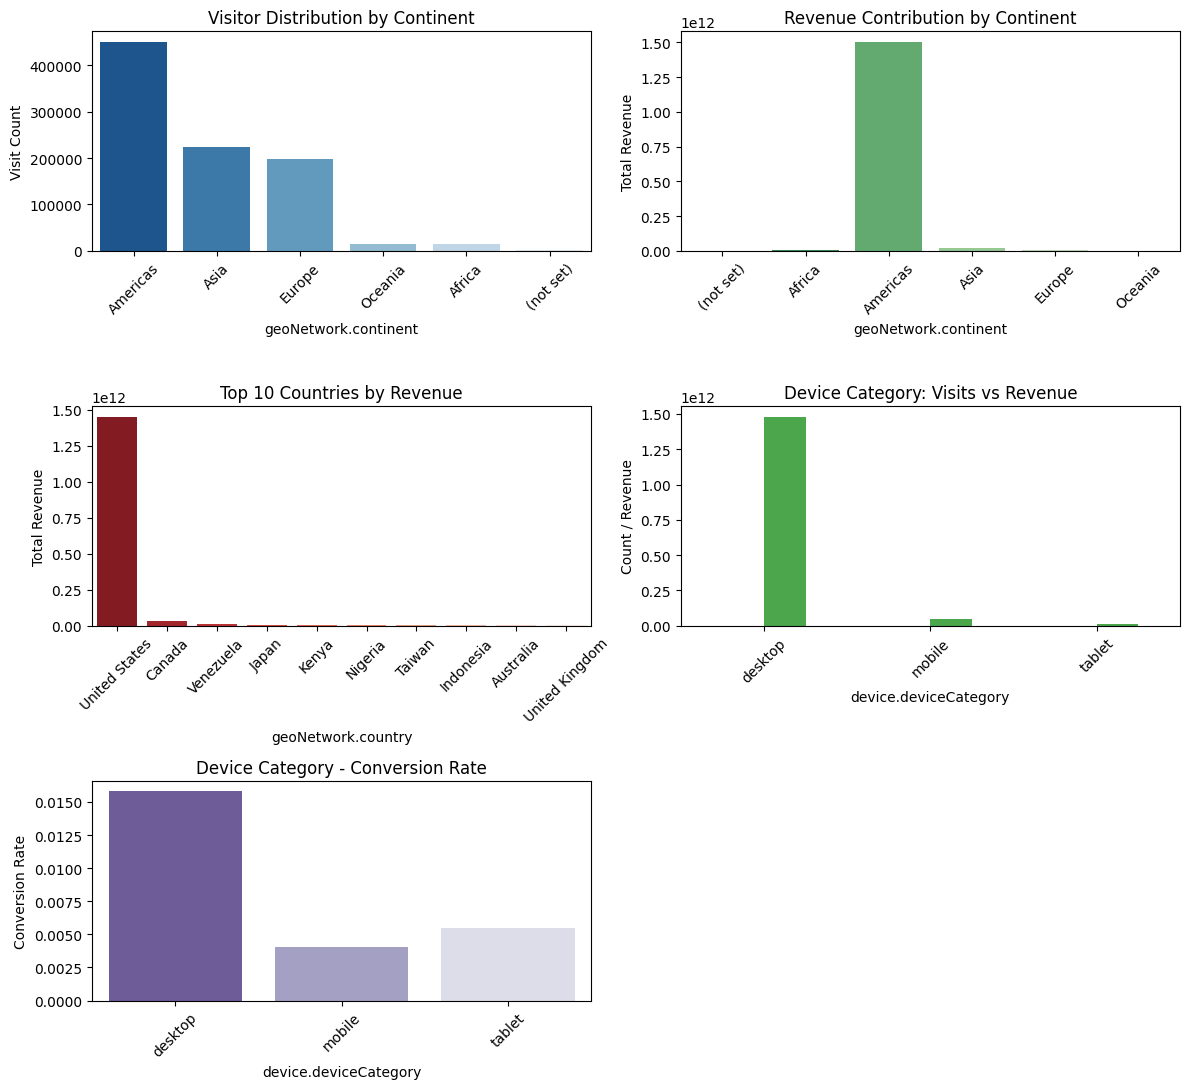

In [112]:
# 대륙별 방문자 수 및 매출 분석
continent_visits = train_df['geoNetwork.continent'].value_counts()
continent_revenue = train_df.groupby('geoNetwork.continent')['totals.transactionRevenue'].sum()

# 국가별 상위 10개국 매출 분석
top_countries = train_df.groupby('geoNetwork.country')['totals.transactionRevenue'].sum().nlargest(10)

# 디바이스 유형별 방문자 수 및 매출 분석
device_visits = train_df['device.deviceCategory'].value_counts()
device_revenue = train_df.groupby('device.deviceCategory')['totals.transactionRevenue'].sum()

# 디바이스별 전환율 계산
device_conversion = train_df.groupby('device.deviceCategory').agg(
    total_sessions=('visitNumber', 'count'),
    total_transactions=('totals.transactionRevenue', lambda x: (x > 0).sum())
)
device_conversion['conversion_rate'] = device_conversion['total_transactions'] / device_conversion['total_sessions']

# 시각화
fig, axes = plt.subplots(3, 2, figsize=(12, 11))

# 대륙별 방문자 수
sns.barplot(x=continent_visits.index, y=continent_visits.values, hue=continent_visits.index, legend=False, ax=axes[0, 0], palette="Blues_r")
axes[0, 0].set_title("Visitor Distribution by Continent")
axes[0, 0].set_ylabel("Visit Count")
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45)

# 대륙별 매출 기여도
sns.barplot(x=continent_revenue.index, y=continent_revenue.values, hue=continent_revenue.index, legend=False, ax=axes[0, 1], palette="Greens_r")
axes[0, 1].set_title("Revenue Contribution by Continent")
axes[0, 1].set_ylabel("Total Revenue")
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45)

# 국가별 상위 10개국 매출
sns.barplot(x=top_countries.index, y=top_countries.values, hue=top_countries.index, legend=False, ax=axes[1, 0], palette="Reds_r")
axes[1, 0].set_title("Top 10 Countries by Revenue")
axes[1, 0].set_ylabel("Total Revenue")
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45)

# 디바이스 유형별 방문자 및 매출 비교
device_data = pd.DataFrame({'Visits': device_visits, 'Revenue': device_revenue})
device_data.plot(kind='bar', ax=axes[1, 1], color=["blue", "green"], alpha=0.7, legend=False)
axes[1, 1].set_title("Device Category: Visits vs Revenue")
axes[1, 1].set_ylabel("Count / Revenue")
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45)

# 디바이스별 전환율 시각화
sns.barplot(x=device_conversion.index, y=device_conversion['conversion_rate'], hue=device_conversion.index, legend=False, ax=axes[2, 0], palette="Purples_r")
axes[2, 0].set_title("Device Category - Conversion Rate")
axes[2, 0].set_ylabel("Conversion Rate")
axes[2, 0].set_xticklabels(axes[2, 0].get_xticklabels(), rotation=45)

# 빈 자리 채우기
axes[2, 1].axis("off")

plt.tight_layout()
plt.show()

#### 1. **대륙별 방문자 및 매출 기여도**  
   - 방문자 수는 **Americas(북미 및 남미 지역)** 에서 가장 많으며, 그다음이 **Asia(아시아), Europe(유럽)** 순이다.  
   - 그러나 매출 기여도를 보면, **Americas 지역이 압도적으로 높은 매출을 차지**하고 있으며, 나머지 지역의 기여도는 매우 낮다. 이는 방문자가 많더라도 구매 전환율이 낮거나 객단가가 낮은 지역이 존재할 가능성을 시사한다.
---
#### 2. **국가별 상위 10개국 매출 분석**  
   - **미국(United States)** 이 압도적으로 높은 매출을 기록하며, 다른 국가들과의 차이가 매우 크다.  
   - **캐나다(Canada), 베네수엘라(Venezuela), 일본(Japan), 케냐(Kenya), 나이지리아(Nigeria)** 등의 국가도 일부 매출을 기록했지만, 미국과의 차이는 상당하다. 이는 미국 시장이 전체 매출의 핵심이며, 다른 국가들에서는 상대적으로 낮은 구매력을 보일 가능성이 있다.
---
#### 3. **디바이스별 방문자 수 및 매출 비교**  
   - 방문자 수는 **데스크탑(Desktop)**이 가장 많으며, **모바일(Mobile)**, **태블릿(Tablet)** 순으로 나타난다.  
   - 매출 역시 **데스크탑이 압도적으로 높은 비중을 차지**하며, 모바일과 태블릿의 매출 기여도는 매우 낮다. 이는 데스크탑 사용자가 구매 가능성이 높은 고객층이라는 것을 의미하며, 데스크탑 환경에서의 UX 최적화가 중요함을 시사한다.
---
#### 4. **디바이스별 전환율 분석**  
   - **데스크탑의 전환율(Conversion Rate)이 가장 높고**, 모바일과 태블릿은 상대적으로 낮은 전환율을 보인다.  
   - 특히, 태블릿은 방문자 수는 적지만 모바일보다 더 높은 전환율을 보이는 점이 눈에 띈다. 이는 태블릿 사용자들이 특정한 목적을 가지고 방문하여 구매로 이어질 가능성이 크다는 점을 시사한다.
---

- **미국(US) 시장이 전체 매출의 핵심**이며, 나머지 국가의 매출 기여도는 크지 않다. 따라서 미국 중심의 마케팅 전략이 필요하며, 국가별로 구매력이 높은 시장을 추가 분석할 필요가 있다.
- **데스크탑이 가장 높은 매출 기여도를 보이며 전환율도 높음** → 데스크탑 UX 최적화가 중요하다.
- **모바일 및 태블릿의 전환율이 낮음** → 모바일 결제 경험 개선, 원클릭 결제 등의 전략이 필요할 수 있다.
- **태블릿은 방문자 수는 적지만 모바일보다 전환율이 높음** → 태블릿 사용자 맞춤 마케팅(고급 제품 추천 등)이 효과적일 가능성이 있다.

### (4) 수익 예측을 위한 상관관계 분석
- totals.transactionRevenue와 다른 변수들간의 상관관계 분석

In [133]:
columns = list(train_df.columns)
columns.remove('totals.transactionRevenue')

corr_df = train_df[columns]
# corr_matrix = corr_df.corr().round(1)

# sns.heatmap(corr_matrix, annot=True, cmap='bwr')

In [ ]:
import pickle

with open('bounce_df.pkl', 'rb') as f :
    bounce_rate_df = pickle.load(f)

In [1]:
print('hello')

hello
